__This noteboebook contains all figures which are used in the thesis and the presentation.__

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as Image
import matplotlib.cm
from matplotlib.gridspec import GridSpec

import torch
import math
import numpy as np
import pandas as pd
import seaborn as sns
import fileinput
import random
from sklearn.preprocessing import minmax_scale
from skimage.io import imread
from operator import attrgetter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import interpolate

from bee_view_analyzer.ModelLoader import *
import bee_view_analyzer.Autoencoder as Autoencoder
import bee_view_analyzer.Dtw as Dtw
import bee_view_analyzer.Utils as Utils
import bee_view_analyzer.Visualizer as Visualizer
import bee_view_analyzer.DataLoader as DataLoader
import bee_view_analyzer.Correlation as Correlation
import bee_view_analyzer.Helper as Helper
import bee_view_analyzer.DistributionTest as DistributionTest

In [ ]:
# Thesis:
latex_image_path = ['07_thesis_figures', 'thesis']
PAGE_WIDTH = 5.74916   # in inch
FONT_SIZE_LABEL = 12

# Presentation:
'''
latex_image_path = ['07thesis_figures', 'presentation']
PAGE_WIDTH = 9   # in inch
FONT_SIZE_LABEL = 18
'''

"\nlatex_image_path = ['05_thesis_figures', 'presentation']\nPAGE_WIDTH = 9   # in inch\nFONT_SIZE_LABEL = 18\n"

In [ ]:
def backend_pgf(fig, file_name):
    matplotlib.use('pgf')

    pgf = {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif", # use serif/main font for text elements
        "text.usetex": True,    # use inline math for ticks
        "pgf.rcfonts": False,   # don't setup fonts from rc parameters
        "pgf.preamble": [
            "\\usepackage{mathpazo}",         # load additional packages
        ]
    }
    matplotlib.rcParams.update(pgf)
    
    path = Utils.get_path(latex_image_path, file_name)
    fig.savefig(path, dpi=600)
    
    # images are saved in subfolder 'images' -> path is not added automatically in pgf file
    
    # remove file ending
    file_name = file_name[ : -4]
    replacement_text = 'images/' +  file_name
    
    with fileinput.FileInput(path, inplace=True) as file:
        for line in file:
            print(line.replace(file_name, replacement_text), end='')
    
def backend_inline(fig = None, file_name = None, transparent=False):
    matplotlib.use('module://ipykernel.pylab.backend_inline')
    
    if fig is not None and file_name is not None:
        path = Utils.get_path(latex_image_path, file_name)
        fig.savefig(path, dpi=600, transparent=transparent)

__Helper:__

In [ ]:
NEURON_DEFAULT = 0
NEURON_AUGUST_FLIGHT_1 = 2

def get_start_round(spike_rate_resolution, flight_day, flight_num, round_num):
    return _get_round(start_rounds, spike_rate_resolution, flight_day, flight_num, round_num)
    
def get_end_round(spike_rate_resolution, flight_day, flight_num, round_num):
    return _get_round(end_rounds, spike_rate_resolution, flight_day, flight_num, round_num)
    
def get_start_lines(spike_rate_resolution, flight_day, flight_num, round_num):
    return _get_round(start_line, spike_rate_resolution, flight_day, flight_num, round_num)
    
def get_end_lines(spike_rate_resolution, flight_day, flight_num, round_num):
    return _get_round(end_line, spike_rate_resolution, flight_day, flight_num, round_num)

def get_camera_positions(flight_day, spike_rate_resolution, flight_num):
    return camera_positions[flight_day][spike_rate_resolution][flight_num]

def get_coords(flight_day, spike_rate_resolution, flight_num):
    return coords[flight_day][spike_rate_resolution][flight_num]

def get_spike_rate(flight_day, spike_rate_resolution, flight_num):
    neuron_num = NEURON_DEFAULT
    
    if flight_day == FLIGHT_DAY_AUGUST and flight_num == 0:
        neuron_num = NEURON_AUGUST_FLIGHT_1
        
    
    return spike_rates[flight_day][spike_rate_resolution][flight_num][neuron_num]

def _get_round(rounds_array, spike_rate_resolution, flight_day, flight_num, round_num):
    time = rounds_array[flight_day][flight_num][round_num]
    
    if type(time) == list:
        time = np.array(time)
                
    if spike_rate_resolution == RES_SMALL:
        time *= 10
    elif spike_rate_resolution == RES_HIGH:
        time //= 10
        
    return time


# Returns spike rate and camera positions without waiting frames between flight rounds.
# Start and end is not removed.
def get_data_wihout_waitings(flight_day, spike_rate_resolution, flight_num):
    spike_rate = get_spike_rate(flight_day, spike_rate_resolution, flight_num)
    
    try:
        camera_positions = get_camera_positions(flight_day, spike_rate_resolution, flight_num)
    except IndexError:
        camera_positions = None
    
    flight_start_rounds = []
    last_round_end = -1
    waiting_frames = 0
    camera_positions_without_waiting = None
    
    for round_num in range(len(start_rounds[flight_day][flight_num])):
        round_start = get_start_round(spike_rate_resolution, flight_day, flight_num, round_num)
        round_end = get_end_round(spike_rate_resolution, flight_day, flight_num, round_num)
        
        if round_num == 0:
            spike_rate_without_waiting = spike_rate[: round_end]
            
            if camera_positions is not None:
                camera_positions_without_waiting = camera_positions[: round_end]
        else:
            prev_round_end = get_end_round(spike_rate_resolution, flight_day, flight_num, round_num - 1)
            waiting_frames += round_start - prev_round_end   
            
            if round_num < len(start_rounds[flight_day][flight_num]) - 1:            
                spike_rate_without_waiting = np.append(spike_rate_without_waiting, spike_rate[round_start : round_end])
                
                if camera_positions is not None:
                    camera_positions_without_waiting = np.append(camera_positions_without_waiting, camera_positions[round_start : round_end], axis = 0)
            else:
                last_round_end = round_end - waiting_frames
                spike_rate_without_waiting = np.append(spike_rate_without_waiting, spike_rate[round_start : ])
                
                if camera_positions is not None:
                    camera_positions_without_waiting = np.append(camera_positions_without_waiting, camera_positions[round_start : ], axis = 0)
            
        
        flight_start_rounds.append(round_start - waiting_frames)
        
    return spike_rate_without_waiting, camera_positions_without_waiting, flight_start_rounds, last_round_end

def get_bin_data(time_series, bin_size, start = 0, end = -1, sum_bins = True):    
    if end == -1:
        end = len(time_series)
    
    bin_chunks = [time_series[x : x + bin_size] for x in range(start, end - (bin_size - 1), bin_size)]        
    
    if sum_bins:
        return np.sum(np.array(bin_chunks), 1)
    
    return bin_chunks

def get_scale_to_seconds(spike_rate_resolution):
    if spike_rate_resolution == RES_SMALL:
        return 100
    elif spike_rate_resolution == RES_MEDIUM:
        return 10
    else:
        return 1

def get_x_values_in_seconds(time_series, spike_rate_resolution, bin_size = -1):
    max_value = len(time_series)
    step = 1
    
    if bin_size > 0:
        max_value *= bin_size
        step *= bin_size
    
    scale = get_scale_to_seconds(spike_rate_resolution)
    
    max_value /= scale
    step /= scale
    
    return np.arange(0, max_value, step=step)

def plot(ax, time_series, labels = None, highlight_regions = None, smoothness = -1, x_values = None,
         show_unsmoothed_points = False, linewidth = 2, color=None):

    if type(time_series) is list:
        time_series_list = time_series
    else:
        time_series_list = []
        time_series_list.append(time_series)

    def plot_smooth(x_scaled_values, series, smoothness, label):
        x = range(len(series))
        y = series
        
        if show_unsmoothed_points:
            x_unsmoothed = x if x_scaled_values is None else x_scaled_values
            plt.plot(x_unsmoothed, y, marker = 'o', markersize = 0.3, linestyle='', label = "SWC")
        
        x_int = np.linspace(x[0], x[-1], len(series))
        tck = interpolate.splrep(x, y, k = 3, s = smoothness)
        y_int = interpolate.splev(x_int, tck, der = 0)
        
        x = x_int if x_scaled_values is None else x_scaled_values
        ax.plot(x, y_int, linestyle = '-', linewidth = linewidth, label=label, color=color)
        
        # instead of splev, rolling mean can be used (produces similar results):
        '''
        y = pd.Series(series).rolling(5).mean()
        x = np.arange(len(series)) if x_scaled_values is None else x_scaled_values
        ax.plot(x, y, linestyle = '-', linewidth = linewidth, label=label)
        '''

    i = 0
    for series_num in range(len(time_series_list)):
        time_series = time_series_list[series_num]
        x = x_values[series_num] if x_values is not None else None

        if type(time_series) is torch.Tensor:
            time_series = time_series.numpy()

        if smoothness > 0:        
            plot_smooth(x, time_series, smoothness, labels[i] if labels != None else None)
        else:
            x_series = x if x is not None else np.linspace(x[0], x[-1], len(series))
            ax.plot(x_series, time_series, label = labels[i] if labels != None else None)

        i += 1

    if labels != None:
        ax.legend(loc='upper right', fontsize=FONT_SIZE_LABEL)

    if highlight_regions != None:
        for i in range(0, len(highlight_regions), 2):
            ax.axvspan(highlight_regions[i], highlight_regions[i + 1], color='green', alpha=0.2)

__Measure scale factor between 1 pixel on map image and 1 meter:__

In [ ]:
# coordinated of two points on map image
a = np.array([612, 390])
b = np.array([378, 65])

img_distance = np.linalg.norm(a-b)
google_maps_meter_distance = 177.43 # distance between same points in meter (measured with google maps)

MAP_SCALE_FACTOR = img_distance / google_maps_meter_distance

MAP_ORIGIN_X = 488 # distance to leftmost x-coordinate from origin on field
MAP_ORIGIN_Y = 675 # distance to topmost y-coordinate from origin on field

def get_field_map(flight_day):
    if flight_day == FLIGHT_DAY_AUGUST:
        return Image.imread(Utils.get_path(['07_thesis_figures'], 'field_2018_08_02.png'))
    else:
        return Image.imread(Utils.get_path(['07_thesis_figures'], 'field_2018_09_03.png'))
    
# returns height, width of field maps
def get_field_map_size():
    return 916, 696

__Load copter's position, spike rate of the bee's brain activity, coordinates of points in the bee's viewing range and motor speed for all 1/10 second frames of all flights:__

In [ ]:
FLIGHT_DAY_AUGUST = 0
FLIGHT_DAY_SEPTEMBER = 1

RES_SMALL = 0   # 0.01 seconds
RES_MEDIUM = 1  # 0.1  seconds
RES_HIGH = 2    # 1    second

# neuro_data[flight_day][spike_rate_resolution][flight_num][neuron][data]
spike_rates = [[[], [], []], [[], [], []]]

# list[flight_day][spike_rate_resolution][flight_num][data]
camera_positions = [[[], [], []], [[], [], []]]
coords = [[[], [], []], [[], [], []]]   

# list[flight_day][spike_rate_resolution][flight_num][motor_num/axis_num][data]
motor_speeds = [[[], [], []], [[], [], []]]
accelerations = [[[], [], []], [[], [], []]]

def load_flight(flight_day, spike_rate_resolution, csv_path, spike_type_rows, start_frame,
                voltage_column, coords_path = None):
    
    spikes = []
    for spike_col in spike_type_rows:
        spikes.append(DataLoader.load_neuro_data(None, csv_path, spike_col, start_frame))
    
    spike_rates[flight_day][spike_rate_resolution].append(spikes)
    
    cam_pos = DataLoader.load_camera_positions(csv_path, voltage_column, start_frame)
    camera_positions[flight_day][spike_rate_resolution].append(cam_pos)
    
    if coords_path is not None:
        coords[flight_day][spike_rate_resolution].append(Utils.load_object(coords_path))
        
    speed, accel = DataLoader.load_motor_speeds(csv_path, voltage_column, start_frame)
    motor_speeds[flight_day][spike_rate_resolution].append(speed)
    accelerations[flight_day][spike_rate_resolution].append(accel)        


csv_path = Utils.get_path(["flights", "flight_2018_09_03#1"],
                          "030918_01_out_adc_synced.csv_spike_rates_0.01s_intervalls.csv")
load_flight(FLIGHT_DAY_SEPTEMBER, RES_SMALL, csv_path, [8], 6000, 9)

csv_path = Utils.get_path(["flights", "flight_2018_09_03#2"],
                          "030918_2_out_adc_synced.csv_spike_rates_0.01s_intervalls.csv")
load_flight(FLIGHT_DAY_SEPTEMBER, RES_SMALL, csv_path, [2], 6000, 3)

csv_path = Utils.get_path(["flights", "flight_2018_09_03#3"],
                          "030918_3_out_adc_synced.csv_spike_rates_0.01s_intervalls.csv")
load_flight(FLIGHT_DAY_SEPTEMBER, RES_SMALL, csv_path, [2], 6000, 3)

csv_path = Utils.get_path(["flights", "flight_2018_09_03#4"],
                          "030918_4_out_adc_synced.csv_spike_rates_0.01s_intervalls.csv")
load_flight(FLIGHT_DAY_SEPTEMBER, RES_SMALL, csv_path, [2], 6000, 3)

csv_path = Utils.get_path(["flights", "flight_2018_08_02#1"],
                          "020818_out_adc_synced.csv.txt_spike_rates_0.01s_intervalls.csv")
load_flight(FLIGHT_DAY_AUGUST, RES_SMALL, csv_path, [2, 3, 4, 5, 6, 8, 9, 10, 11], 0, 12)

csv_path = Utils.get_path(["flights", "flight_2018_08_02#2"],
                          "020818_out_adc_synced.csv_spike_rates_0.01s_intervalls.csv")
load_flight(FLIGHT_DAY_AUGUST, RES_SMALL, csv_path, [2], 0, 3)


csv_path = Utils.get_path(["flights", "flight_2018_09_03#1"],
                          "030918_01_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv")
coord_path = Utils.get_path(["flights", "flight_2018_09_03#1"], "coords.dill")
load_flight(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, csv_path, [8], 600, 9, coord_path)

csv_path = Utils.get_path(["flights", "flight_2018_09_03#2"],
                          "030918_2_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv")
coord_path = Utils.get_path(["flights", "flight_2018_09_03#2"], "coords.dill")
load_flight(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, csv_path, [2], 600, 3, coord_path)

csv_path = Utils.get_path(["flights", "flight_2018_09_03#3"],
                          "030918_3_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv")
coord_path = Utils.get_path(["flights", "flight_2018_09_03#3"], "coords.dill")
load_flight(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, csv_path, [2], 600, 3, coord_path)

csv_path = Utils.get_path(["flights", "flight_2018_09_03#4"],
                          "030918_4_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv")
coord_path = Utils.get_path(["flights", "flight_2018_09_03#4"], "coords.dill")
load_flight(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, csv_path, [2], 600, 3, coord_path)

csv_path = Utils.get_path(["flights", "flight_2018_08_02#1"],
                          "020818_out_adc_synced.csv.txt_spike_rates_0.1s_intervalls.csv")
coord_path = Utils.get_path(["flights", "flight_2018_08_02#1"], "coords.dill")
load_flight(FLIGHT_DAY_AUGUST, RES_MEDIUM, csv_path, [2, 3, 4, 5, 6, 8, 9, 10, 11], 0, 12, coord_path)

csv_path = Utils.get_path(["flights", "flight_2018_08_02#2"],
                          "020818_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv")
coord_path = Utils.get_path(["flights", "flight_2018_08_02#2"], "coords.dill")
load_flight(FLIGHT_DAY_AUGUST, RES_MEDIUM, csv_path, [2], 0, 3, coord_path)



csv_path = Utils.get_path(["flights", "flight_2018_09_03#1"],
                          "030918_01_out_adc_synced.csv_spike_rates_1.0s_intervalls.csv")
load_flight(FLIGHT_DAY_SEPTEMBER, RES_HIGH, csv_path, [8], 60, 9)

csv_path = Utils.get_path(["flights", "flight_2018_09_03#2"],
                          "030918_2_out_adc_synced.csv_spike_rates_1.0s_intervalls.csv")
load_flight(FLIGHT_DAY_SEPTEMBER, RES_HIGH, csv_path, [2], 60, 3)

csv_path = Utils.get_path(["flights", "flight_2018_09_03#3"],
                          "030918_3_out_adc_synced.csv_spike_rates_1.0s_intervalls.csv")
load_flight(FLIGHT_DAY_SEPTEMBER, RES_HIGH, csv_path, [2], 60, 3)

csv_path = Utils.get_path(["flights", "flight_2018_09_03#4"],
                          "030918_4_out_adc_synced.csv_spike_rates_1.0s_intervalls.csv")
load_flight(FLIGHT_DAY_SEPTEMBER, RES_HIGH, csv_path, [2], 60, 3)

# 1s csv differ from 0.1s and 0.01s -> they are not used!
for flight_num in range(2):
    binned_spike_rates = []
    
    for neuron_num in range(len(spike_rates[FLIGHT_DAY_AUGUST][RES_MEDIUM][flight_num])):
        spike_rate = spike_rates[FLIGHT_DAY_AUGUST][RES_MEDIUM][flight_num][neuron_num]
        binned_spike_rates.append(get_bin_data(spike_rate, 10))

    spike_rates[FLIGHT_DAY_AUGUST][RES_HIGH].append(binned_spike_rates)

__Load start and end frames of all rounds and lines for all flights:__

In [ ]:
# start_rounds[flight_day][flight_num][data]
start_rounds = [[[4230, 5850, 7430],
                [2130, 3730, 5300, 6940, 8575]],
                
                [[630, 2900, 4580],
                [743, 2390, 4070, 5770],
                [110, 1950, 3650, 5330],
                [330, 1980, 3650]]]      # exclude last round (flight route not finished, starts at 5330)

end_rounds = [[[5690, 7310, 8890],
              [3550, 5170, 6790, 8380, 10016]],
              
              [[2120, 4370, 6050],
              [2220, 3880, 5555, 7220],
              [1600, 3440, 5150, 6795],
              [1800, 3450, 5120]]]      # exclude last round (flight route not finished, ends at 6750)

# start_line[flight_day][flight_num][round_num][line_num][data]
start_line = [[[[4274, 4815, 5133, 5505], [5885, 6423, 6647, 6742, 7115], [7478, 8010, 8342, 8710]],
               [[2136, 2666, 3008, 3385], [3758, 4282, 4511, 4612, 4978], [5356, 5895, 6234, 6595], [6964, 7517, 7841, 8219], [8581, 9122, 9448, 9815]]],
    
             [[[630, 1190, 1536, 1921], [2900, 3462, 3786, 4183], [4580, 5135, 5481, 5866]],
              [[743, 1300, 1630, 2025], [2390, 2965, 3310, 3700], [4070, 4640, 4970, 5370], [5770, 6315, 6665, 7050]],
              [[110, 650, 1000, 1400], [1950, 2500, 2850, 3240], [3650, 4200, 4550, 4930], [5330, 5870, 6215, 6600]],
              [[330, 870, 1200, 1590], [1980, 2530, 2870, 3250], [3650, 4200, 4530, 4920], [5330, 5870, 6220, 6480]]]]

end_line = [[[[4692, 4996, 5314, 5684], [6291, 6600, 6920, 7291], [7886, 8193, 8523, 8882]],
             [[2550, 2865, 3190, 3546], [4146, 4466, 4798, 5161], [5766, 6088, 6415, 6785], [7395, 7705, 8036, 8394], [8990, 9304, 9635, 10009]]],
            
            [[[1034, 1385, 1720, 2117], [3300, 3651, 3979, 4368], [4981, 5327, 5646, 6050]],
             [[1145, 1490, 1815, 2220], [2805, 3165, 3485, 3880], [4480, 4820, 5145, 5555], [6150, 6505, 6825, 7220]],
             [[510, 870, 1200, 1600], [2350, 2720, 3050, 3440], [4070, 4420, 4750, 5150], [5740, 6070, 6420, 6795]],
             [[740, 1070, 1400, 1800], [2400, 2750, 3070, 3450], [4050, 4400, 4730, 5120], [5740, 6090, 6410, 6750]]]]

# Chapter 4: Spike Rate

## Descritpion

### Thesis

In [ ]:
def plot_mean_raw_spike_rates(spike_rate_resolution, use_pgf = False, file_name = None, bin_size = -1):    
    flight_day_count = 2
    fig = plt.figure(figsize=(PAGE_WIDTH, flight_day_count * 1.8))
    
    for flight_day in range(flight_day_count):
        ax = fig.add_subplot(flight_day_count, 1, flight_day + 1)
        
        all_rounds = []

        for flight_num in range(len(spike_rates[flight_day][spike_rate_resolution])):
            spike_rate = get_spike_rate(flight_day, spike_rate_resolution, flight_num)

            if bin_size > 1:
                spike_rate = get_bin_data(spike_rate, bin_size)
            
            for round_num in range(len(start_rounds[flight_day][flight_num])):
                start = get_start_round(spike_rate_resolution, flight_day, flight_num, round_num)
                end = get_end_round(spike_rate_resolution, flight_day, flight_num, round_num)

                if bin_size > 1:
                    start = start // bin_size
                    end = end // bin_size
                
                all_rounds.append(spike_rate[start : end])

        # cut endings of rounds such that all rounds are equally long
        min_length = min(len(l) for l in all_rounds)
        all_rounds = [l[ : min_length] for l in all_rounds]

        rounds = np.array(all_rounds)

        mean = np.mean(rounds, axis = 0)
        std = np.std(rounds, axis = 0)
        
        x = get_x_values_in_seconds(mean, spike_rate_resolution, bin_size)    
        ax.plot(x, mean, 'k-')

        ax.fill_between(x, mean - std, mean + std, alpha = 0.5)
        
        #highlight turns (take times of first round)
        scale = get_scale_to_seconds(spike_rate_resolution)
        start = get_start_round(spike_rate_resolution, flight_day, flight_num=0, round_num=0) // scale
        start_lines = get_start_lines(spike_rate_resolution, flight_day, flight_num=0, round_num=0) // scale
        end_lines = get_end_lines(spike_rate_resolution, flight_day, flight_num=0, round_num=0)  // scale
        
        for i in range(len(start_lines) - 1):
            ax.axvspan(end_lines[i] - start, start_lines[i + 1] - start, color='orange', alpha=0.2)
        
    fig.text(0.5, 0.02, 'time [s]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.02, 0.5, 'spike rate [spikes/s]', ha='center', va='center', rotation='vertical',
             fontsize = FONT_SIZE_LABEL)
    
    fig.text(0.98, 0.75, '(a)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.3, '(b)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    fig.set_facecolor("w")
    
    fig.tight_layout()
    fig.subplots_adjust(left=0.1,bottom=0.15, right=0.95)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show()

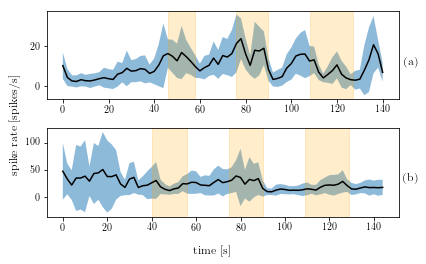

In [ ]:
plot_mean_raw_spike_rates(RES_MEDIUM, bin_size=20)

In [ ]:
plot_mean_raw_spike_rates(RES_MEDIUM, bin_size=20, use_pgf = True, file_name = 'mean_spike_rate.pgf')

### Presentation

In [ ]:
def plot_flight_spike_rate(flight_day, spike_rate_resolution, flight_num, use_pgf = False, file_name = None,
                           bin_size = -1, highlight=-1, small=False):
    
    fig = plt.figure(figsize=(PAGE_WIDTH, 1.7 if small else 2.6))
    ax = fig.add_subplot(111)
    
    spike_rate = get_spike_rate(flight_day, spike_rate_resolution, flight_num)
    
    if bin_size > 1:
        spike_rate = get_bin_data(spike_rate, bin_size)
    
    x = get_x_values_in_seconds(spike_rate, spike_rate_resolution, bin_size)    
    ax.plot(x, spike_rate, 'k-')
        
    #highlight sections of flight
    scale = get_scale_to_seconds(spike_rate_resolution)
    round_count = len(start_rounds[flight_day][flight_num])
    
    start_first_round = get_start_round(spike_rate_resolution, flight_day, flight_num, round_num=0) // scale
    end_last_round = get_end_round(spike_rate_resolution, flight_day, flight_num,
                                   round_num=round_count - 1) // scale
    
    if highlight > 0:
        ax.axvspan(0, start_first_round - 1, color='red', alpha=0.2)
        ax.axvspan(end_last_round + 1, len(spike_rate) * bin_size // scale, color='red', alpha=0.2)
    
    for round_num in range(round_count):
        start = get_start_round(spike_rate_resolution, flight_day, flight_num, round_num) // scale
        end = get_end_round(spike_rate_resolution, flight_day, flight_num, round_num) // scale
        
        if highlight > 1:
            ax.axvspan(start, end, color='orange', alpha=0.2)
        
        if highlight > 2 and round_num > 0:
            end_prev_round = get_end_round(spike_rate_resolution, flight_day, flight_num,
                                           round_num=round_num - 1) // scale
            
            ax.axvspan(end_prev_round + 1, start - 1, color='gray', alpha=0.2)
    
    fig.set_facecolor("w")    
    fig.tight_layout()
    
    if small:
        fig.subplots_adjust(left=0.09,bottom=0.27, top=0.95, right=0.95)
        fig.text(0.02, 0.6, 'Spike Rate', ha='center', va='center', rotation='vertical',
                 fontsize = FONT_SIZE_LABEL)
        fig.text(0.5, 0.06, 'Zeit [s]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    else:
        fig.subplots_adjust(left=0.09,bottom=0.23, right=0.95)    
        fig.text(0.02, 0.6, 'Spike Rate', ha='center', va='center', rotation='vertical',
                 fontsize = FONT_SIZE_LABEL)
        fig.text(0.5, 0.05, 'Zeit [s]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show()

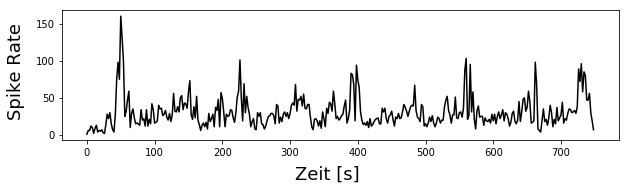

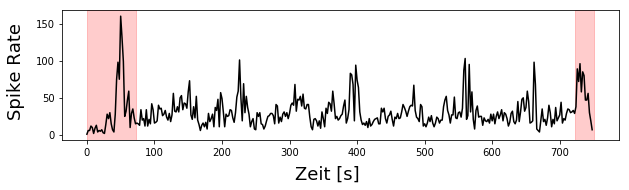

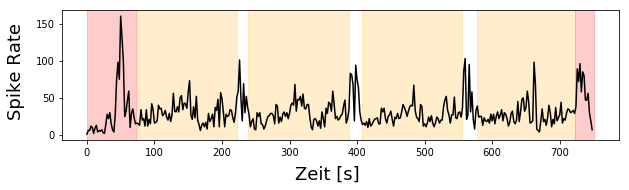

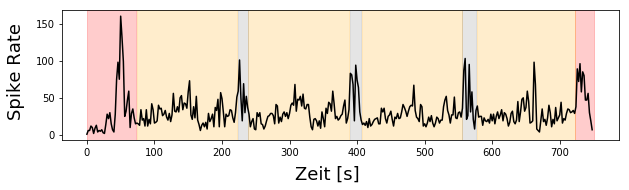

In [ ]:
plot_flight_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=1, bin_size = 20,
                       file_name = "spike_rate_september_0.png", highlight = 0)

plot_flight_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=1, bin_size = 20,
                       file_name = "spike_rate_september_1.png", highlight = 1)

plot_flight_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=1, bin_size = 20,
                       file_name = "spike_rate_september_2.png", highlight = 2)

plot_flight_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=1, bin_size = 20,
                       file_name = "spike_rate_september_3.png", highlight = 3)

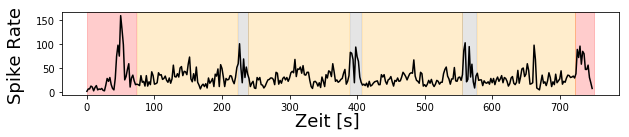

In [ ]:
plot_flight_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=1, use_pgf = False,
                       file_name = "spike_rate_september_small.png", bin_size = 20, highlight = 3, small = True)

In [ ]:
def plot_flight_spike_rate_without_waiting_times(flight_day, spike_rate_resolution, flight_num, use_pgf = False,
                                                 file_name = None, bin_size = -1, highlight=-1, small=False):
    
    fig = plt.figure(figsize=(PAGE_WIDTH, 1.7 if small else 2.6))
    ax = fig.add_subplot(111)
    
    spike_rate, _, flight_start_rounds, last_round_end = get_data_wihout_waitings(flight_day,
                                                                                  spike_rate_resolution,
                                                                                  flight_num)
    spike_rate = spike_rate[flight_start_rounds[0] : last_round_end]
    
    if bin_size > 1:
        spike_rate = get_bin_data(spike_rate, bin_size)
    
    x = get_x_values_in_seconds(spike_rate, spike_rate_resolution, bin_size)    
    ax.plot(x, spike_rate, 'k-')
        
    #highlight sections of flight
    scale = get_scale_to_seconds(spike_rate_resolution)
    round_count = len(start_rounds[flight_day][flight_num])
    
    start_first_round = get_start_round(spike_rate_resolution, flight_day, flight_num, round_num=0) // scale
    last_round_end = last_round_end // scale
    
    #f highlight > 0:
    #   ax.axvspan(0, start_first_round - 1, color='red', alpha=0.2)
    #   ax.axvspan(last_round_end + 1, len(spike_rate) * bin_size // scale, color='red', alpha=0.2)
    
    for round_start in flight_start_rounds[1:]:
        round_start = (round_start - flight_start_rounds[0]) // scale
        
        ax.axvspan(round_start - 1, round_start + 1, color='blue', alpha=0.2)
    
    fig.set_facecolor("w")    
    fig.tight_layout()
    
    if small:
        fig.subplots_adjust(left=0.09,bottom=0.27, top=0.95, right=0.95)
        fig.text(0.02, 0.6, 'Spike Rate', ha='center', va='center', rotation='vertical', fontsize=FONT_SIZE_LABEL)
        fig.text(0.5, 0.06, 'Zeit [s]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    else:
        fig.subplots_adjust(left=0.09,bottom=0.23, right=0.95)    
        fig.text(0.02, 0.5, 'Spike Rate [spikes/s]', ha='center', va='center', rotation='vertical',
                 fontsize = FONT_SIZE_LABEL)
        
        fig.text(0.5, 0.05, 'Zeit [s]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show()

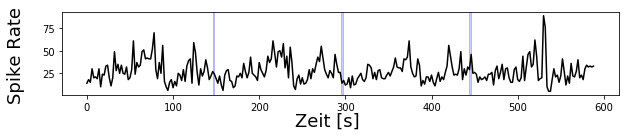

In [ ]:
plot_flight_spike_rate_without_waiting_times(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=1, use_pgf = False,
                       file_name = "spike_rate_september_short.png", bin_size = 20, highlight = 3, small = True)

## Sliding Window Correlation

### Thesis

In [ ]:
def plot_swc_all_days(spike_rate_resolution, bin_size, use_pgf = False, file_name = None):
    all_flights = 4 + 2
    fig = plt.figure(figsize=(PAGE_WIDTH, all_flights * 1.2))
    ax_num = 1
    
    labels = ["Round {}".format(i + 1) for i in range(5)]
    
    for flight_day in range(2):
        flight_count = len(start_rounds[flight_day])
        
        ax = None

        for flight_num in range(flight_count):
            if ax is None:
                ax = fig.add_subplot(all_flights, 1, ax_num)
            else:
                ax = fig.add_subplot(all_flights, 1, ax_num, sharex=ax, sharey=ax)
                
            ax_num += 1

            spike_rate, _, flight_start_rounds, last_round_end = get_data_wihout_waitings(flight_day,
                                                                                          spike_rate_resolution,
                                                                                          flight_num)

            bin_data = get_bin_data(spike_rate, bin_size)
            corrs = []

            for round_num in range(len(flight_start_rounds)):
                start = flight_start_rounds[round_num]

                if round_num < len(flight_start_rounds) - 1:
                    end = flight_start_rounds[round_num + 1]
                else:
                    end = last_round_end

                corr = Correlation.swc(bin_data, start // bin_size, end // bin_size)
                corr = corr[flight_start_rounds[0] // bin_size
                            : flight_start_rounds[len(flight_start_rounds) - 1] // bin_size]

                corrs.append(corr)

            margin = 1
            highlight = []
            scale = get_scale_to_seconds(spike_rate_resolution)

            for start_round in flight_start_rounds:
                highlight.append(((start_round - flight_start_rounds[0]) // scale) - margin)
                highlight.append(((start_round - flight_start_rounds[0]) // scale) + margin)

            x = [get_x_values_in_seconds(corrs[i], spike_rate_resolution, bin_size) for i in range(len(corrs))]
            labels_axis = labels if flight_day == 0 and flight_num == 1 else None
            plot(ax, corrs, labels = labels_axis, highlight_regions=highlight, smoothness = 1, x_values=x,
                linewidth = 1)

            if flight_day == 0 and flight_num == 1:
                plt.legend(bbox_to_anchor=(-0.15, 2.5, 1.26, 1), loc="lower left", mode="expand", borderaxespad=0,
                           ncol=5, fontsize = FONT_SIZE_LABEL, handlelength=1.0)
                
            bbox=plt.gca().get_position()
            offset = 0.03
            plt.gca().set_position([bbox.x0, bbox.y0 + offset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
                        
            # padding to plots of second flight day
            if flight_day == 1:
                bbox=plt.gca().get_position()
                offset = -0.05
                plt.gca().set_position([bbox.x0, bbox.y0 + offset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
                
            # highlight one oscillation
            if flight_day == 0 and flight_num == 0:
                ax.axvspan(70, 95, color='red', alpha=0.1)
                
            ax.get_xaxis().set_visible(False)
        ax.get_xaxis().set_visible(True)
            
    
    fig.text(0.98, 0.855, '(a)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.722, '(b)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.55, '(c)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.415, '(d)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.285, '(e)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.16, '(f)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    fig.text(0.5, 0.04, 'time [s]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.02, 0.5, 'pearson correlation', ha='center', va='center', rotation='vertical',
             fontsize = FONT_SIZE_LABEL)
    
    fig.set_facecolor("w")
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.plot()

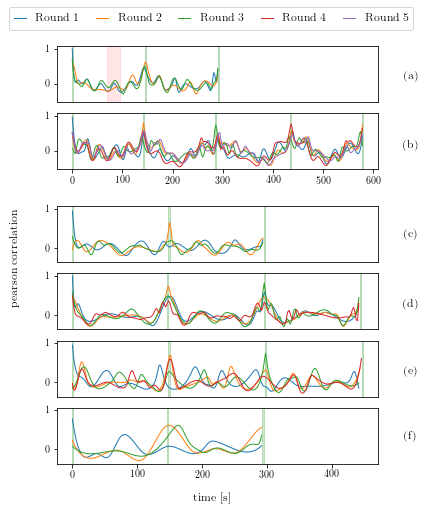

In [ ]:
plot_swc_all_days(RES_MEDIUM, 20)

In [ ]:
plot_swc_all_days(RES_MEDIUM, 20, file_name = 'spike_rate_autocorrelation.png')
plot_swc_all_days(RES_MEDIUM, 20, use_pgf=True, file_name='spike_rate_autocorrelation.pgf')

### Presentation

In [ ]:
def plot_swc_presentation(flight_day, spike_rate_resolution, bin_size, use_pgf = False, file_name = None):
    flight_count = len(start_rounds[flight_day])
    fig = plt.figure(figsize=(PAGE_WIDTH, (2 + flight_count) * 2.5))
    
    labels = ["Runde {}".format(i + 1) for i in range(5)]
    ax = None
    
    for flight_num in range(flight_count):
        if ax is None:
            ax = fig.add_subplot(flight_count + 2, 1, flight_num + 1)
        else:
            ax = fig.add_subplot(flight_count + 2, 1, flight_num + 1, sharex=ax, sharey=ax)

        spike_rate, _, flight_start_rounds, last_round_end = get_data_wihout_waitings(flight_day,
                                                                                      spike_rate_resolution,
                                                                                      flight_num)

        bin_data = get_bin_data(spike_rate, bin_size)
        corrs = []

        for round_num in range(len(flight_start_rounds)):
            start = flight_start_rounds[round_num]

            if round_num < len(flight_start_rounds) - 1:
                end = flight_start_rounds[round_num + 1]
            else:
                end = last_round_end
                
            corr = Correlation.swc(bin_data, start // bin_size, end // bin_size)
            corr = corr[flight_start_rounds[0] // bin_size
                        : flight_start_rounds[len(flight_start_rounds) - 1] // bin_size]
            
            corrs.append(corr)

        margin = 1
        highlight = []
        scale = get_scale_to_seconds(spike_rate_resolution)

        for start_round in flight_start_rounds:
            highlight.append(((start_round - flight_start_rounds[0]) // scale) - margin)
            highlight.append(((start_round - flight_start_rounds[0]) // scale) + margin)
        
        x = [get_x_values_in_seconds(corrs[i], spike_rate_resolution, bin_size) for i in range(len(corrs))]
        labels_axis = labels if flight_num == 1 else None
        plot(ax, corrs, labels = labels_axis, highlight_regions=highlight, smoothness = 1, x_values=x,
            linewidth = 1)
        
        if flight_num == 1:
            plt.legend(bbox_to_anchor=(0, 2.27, 1, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=5,
                      fontsize = FONT_SIZE_LABEL)
            
        if flight_num > 1 or flight_day == FLIGHT_DAY_AUGUST and flight_num == 1:
            ax.get_yaxis().set_visible(False)
            
        if flight_day == FLIGHT_DAY_SEPTEMBER and flight_num == 0 or flight_num == 2:
            ax.get_xaxis().set_visible(False)
    
    fig.text(0.5, 0.04, 'Zeit [s]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.06, 0.5, 'Korrelation', ha='center', va='center', rotation='vertical', fontsize = FONT_SIZE_LABEL)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.plot()

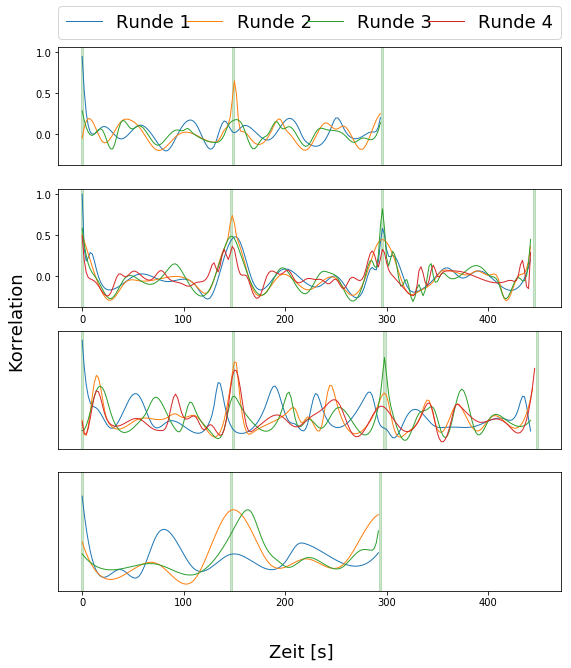

In [ ]:
plot_swc_presentation(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, bin_size = 20, file_name = "swc_september.png")

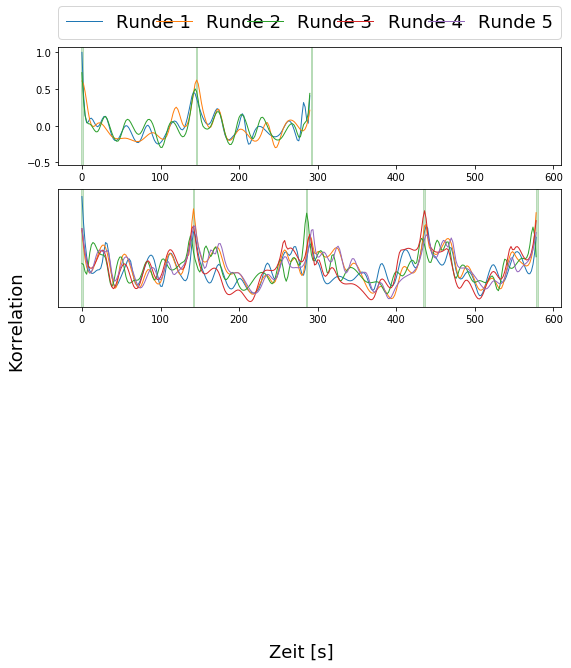

In [ ]:
plot_swc_presentation(FLIGHT_DAY_AUGUST, RES_MEDIUM, bin_size = 20, file_name = "swc_august.png")

In [ ]:
def plot_single_swc(flight_day, spike_rate_resolution, flight_num, base_rounds, bin_size,
                    show_round_starts= False, show_legend=False, use_pgf = False, file_name = None):
    
    fig = plt.figure(figsize=(PAGE_WIDTH, 1.7))
    ax_num = 1
    
    labels = ["Round {}".format(i + 1) for i in range(5)]
    
    ax = fig.add_subplot(111)
    
    spike_rate, _, flight_start_rounds, last_round_end = get_data_wihout_waitings(flight_day,
                                                                                  spike_rate_resolution,
                                                                                  flight_num)
    
    bin_data = get_bin_data(spike_rate, bin_size)
    corrs = []

    for round_num in base_rounds:
        start = flight_start_rounds[round_num]

        if round_num < len(flight_start_rounds) - 1:
            end = flight_start_rounds[round_num + 1]
        else:
            end = last_round_end

        corr = Correlation.swc(bin_data, start // bin_size, end // bin_size)
        corr = corr[flight_start_rounds[0] // bin_size
                    : flight_start_rounds[len(flight_start_rounds) - 1] // bin_size]

        corrs.append(corr)
    
    highlight = []
    
    if show_round_starts:
        margin = 1
        scale = get_scale_to_seconds(spike_rate_resolution)

        for start_round in flight_start_rounds:
            highlight.append(((start_round - flight_start_rounds[0]) // scale) - margin)
            highlight.append(((start_round - flight_start_rounds[0]) // scale) + margin)
            
    x = [get_x_values_in_seconds(corrs[i], spike_rate_resolution, bin_size) for i in range(len(corrs))]
    labels_axis = labels if flight_day == 0 and flight_num == 1 else None
    plot(ax, corrs, labels = labels_axis, highlight_regions=highlight, smoothness = -1, x_values=x,
         linewidth = 1)
    
    if show_legend:
        plt.legend(bbox_to_anchor=(-0.15, 2.5, 1.26, 1), loc="lower left", mode="expand", borderaxespad=0, ncol=5,
                   fontsize = FONT_SIZE_LABEL, handlelength=1.0)
    
    fig.text(0.5, 0.06, 'Zeit [s]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.02, 0.6, 'Korrelation', ha='center', va='center', rotation='vertical', fontsize = FONT_SIZE_LABEL)
    
    fig.set_facecolor("w")
    fig.subplots_adjust(left=0.09,bottom=0.27, top=0.95, right=0.95)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.plot()

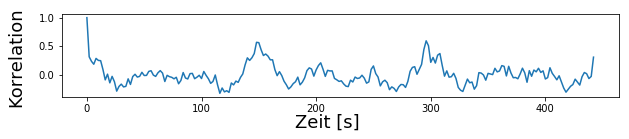

In [ ]:
plot_single_swc(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=1, base_rounds=[0], bin_size=20,
                show_round_starts= False, show_legend=False, file_name = "swc_single.png")

## Length correction

In [ ]:
def _remove_turns(time_series, flight_day, flight_num, spike_rate_resolution):
    time_series_no_turns = []
    current_index = 0
    
    for round_num in range(len(start_rounds[flight_day][flight_num])):
        starts = get_start_lines(spike_rate_resolution, flight_day, flight_num, round_num)
        ends = get_end_lines(spike_rate_resolution, flight_day, flight_num, round_num)
        
        for line_num in range(len(starts) - 1):            
            time_series_no_turns.extend(time_series[current_index : ends[line_num]])
            current_index = starts[line_num + 1]
           
    time_series_no_turns.extend(time_series[current_index : ])
    
    return time_series_no_turns

def get_points(flight_day, flight_num, spike_rate_resolution, lines_only=False):
    points = []
    camera_positions = get_camera_positions(flight_day, spike_rate_resolution, flight_num)
    
    if lines_only:
        camera_positions = _remove_turns(camera_positions, flight_day, flight_num, spike_rate_resolution)
    
    for i in range(len(camera_positions)):
        points.append([camera_positions[i][0], camera_positions[i][2]])
    
    return points

# mean points fixed every 'distance' meter
def create_mean_parts(distance, points, flight_day, flight_num, spike_rate_resolution, lines_only=False):
    dst = np.linalg.norm(np.array(points[ : -1]) - np.array(points[1 : ]), axis = 1)
    spike_rate = get_spike_rate(flight_day, spike_rate_resolution, flight_num)
    
    if lines_only:
        spike_rate = _remove_turns(spike_rate, flight_day, flight_num, spike_rate_resolution)
    
    ordered_points = []
    mean_points = []

    ordered_neuro = []

    current_distance = 0
    current_mean = None
    current_point_list = [points[0]]
    current_neuro_list = [spike_rate[0]]

    half_distance = distance / 2
    p = 0

    for i in range(1, min(len(points), len(spike_rate))):
        dist = dst[i - 1]
        current_distance += dist
        
        # if half of the distance is reached, calculate the exact position
        # of the half distance point (= mean) between last point and current point
        if current_mean is None and current_distance > half_distance:                
            current_element = np.array(points[i])
            prev_element = np.array(current_point_list[-1])
            dst_to_prev =  np.linalg.norm(current_element - prev_element)
                
            p = ((current_distance - half_distance) / dst_to_prev)
            current_mean = current_element + (prev_element - current_element) * p

        # if distance is reached, the calculated mean point as well as all positions and
        # spike rate values are saved and new lists are started
        if current_distance > distance:            
            mean_points.append(current_mean)
            current_mean = None

            ordered_points.append(current_point_list)
            ordered_neuro.append(current_neuro_list)
            
            current_distance -= distance

            current_point_list = [points[i]]
            current_neuro_list = [spike_rate[i]]
        else:
            current_point_list.append(points[i])
            current_neuro_list.append(spike_rate[i])
                
            
    return ordered_points, mean_points, ordered_neuro


def draw_mean_points(points, ax = None, color_value=1.0):
    map_height, map_width = get_field_map_size()
    img_map = np.full((map_height, map_width), np.nan)
        
    round_started = False
    i = -1
    for point in points:
        i += 1
        
        x = int(np.around(MAP_ORIGIN_X + MAP_SCALE_FACTOR * point[0]))
        y = int(np.around(MAP_ORIGIN_Y - MAP_SCALE_FACTOR * point[1]))

        if y < 0 or x < 0 or y >= img_map.shape[0] or x >= img_map.shape[1]:
            if round_started:
                break
                
            continue
        
        img_map[y - 2 : y + 2, x - 2 : x + 2] = color_value
        
        if y < 300:
            round_started = True
            
    img_map = img_map[180:760, 80 : 450]
    
    if ax is None:        
        plt.figure(figsize = (15,15))
        plt.imshow(img_map, cmap = plt.cm.hsv, vmin = 0., vmax = 1.)
    else:
        ax.axis('off')
        ax.imshow(img_map, cmap = plt.cm.hsv, vmin = 0., vmax = 1.)
    
def draw_round_points(points, ax = None):
    map_height, map_width = get_field_map_size()
    img_map = np.full((map_height, map_width), np.nan)
    
    for part_num in range(len(points)):
        for point in points[part_num]:
            x = int(np.around(MAP_ORIGIN_X + MAP_SCALE_FACTOR * point[0]))
            y = int(np.around(MAP_ORIGIN_Y - MAP_SCALE_FACTOR * point[1]))

            img_map[y - 2 : y + 2, x - 2 : x + 2] = 0.3 if part_num % 2 == 0 else 0.7
        
    img_map = img_map[180:760, 80 : 450]
    
    if ax is None:
        plt.figure(figsize = (15,15))
        plt.imshow(img_map, cmap = plt.cm.hsv, vmin = 0., vmax = 1.)
    else:
        ax.axis('off')
        ax.imshow(img_map, cmap = plt.cm.hsv, vmin = 0., vmax = 1.)
    
def _drop_wrong_rounds(start_frames, end_frames):
    if len(start_frames) > len(end_frames):
        start_frames = start_frames[ : -1]

    round_lengths = np.array(end_frames) - np.array(start_frames)
    median = np.median(round_lengths)

    starts = []
    ends = []
    for i in range(len(round_lengths)):
        if round_lengths[i] > 0.7 * median:
            starts.append(start_frames[i])
            ends.append(end_frames[i])
            
    return starts, ends

def get_round_start_end(flight_day, spike_rate_resolution, flight_num = -1, min_frame_number = -1,
                        max_frame_number = -1, lines_only=False):    
    starts = []
    ends = []
    
    round_area_y = MAP_SCALE_FACTOR * 330
    round_area_x = MAP_SCALE_FACTOR * 258
    
    for flight_number in range(len(camera_positions[flight_day][spike_rate_resolution])):
        if flight_num >= 0 and flight_number != flight_num:
            continue
        
        cam_pos = get_camera_positions(flight_day, spike_rate_resolution, flight_number)
        
        if lines_only:
            cam_pos = _remove_turns(cam_pos, flight_day, flight_num, spike_rate_resolution)
        
        start_frames = []
        end_frames = []

        round_flying = False

        frame_num = -1
        for i in range(len(cam_pos)):
            frame_num += 1
            
            if frame_num < min_frame_number:
                continue
            elif max_frame_number > -1 and frame_num > max_frame_number:
                break
            
            x = int(MAP_ORIGIN_X + MAP_SCALE_FACTOR * np.around(cam_pos[i][0]))
            y = int(MAP_ORIGIN_Y - MAP_SCALE_FACTOR * np.around(cam_pos[i][2]))

            if not round_flying and y < round_area_y and x < round_area_x:
                round_flying = True
                start_frames.append(i)
            elif round_flying and y >= round_area_y or x >= round_area_x:
                round_flying = False
                end_frames.append(i)
        
        start_frames, end_frames = _drop_wrong_rounds(start_frames, end_frames)
        
        if flight_num >= 0:
            return start_frames, end_frames
        
        starts.append(start_frames)
        ends.append(end_frames)
    
    return starts, ends
            
def get_base_round(round_num, start_frames, end_frames, ordered_points, mean_points, ordered_neuro):
    current_frame_num = 0
    mean_start_index = -1
    mean_end_index = -1
    base_neuro = []
    
    # fetch start and end batches of points and spike rates in distance seperated lists
    for part_num in range(len(ordered_points)):
        current_frame_num += len(ordered_points[part_num])
        
        if mean_start_index == -1 and current_frame_num >= start_frames[round_num]:
            mean_start_index = part_num
            mean_part_start = start_frames[round_num] - current_frame_num
        elif mean_end_index == -1 and current_frame_num >= end_frames[round_num]:
            mean_end_index = part_num
            mean_part_end = end_frames[round_num] - current_frame_num
            break
    
    # remove spike rate values at start of first batch and end of last batch which
    # do not belong to the specified round
    round_points = ordered_points[mean_start_index : mean_end_index + 1]
    round_points[0] = round_points[0][mean_part_start : ]
    
    round_neuro = ordered_neuro[mean_start_index : mean_end_index + 1]
    round_neuro[0] = round_neuro[0][mean_part_start : ]
    
    if mean_part_end != 0:
        round_points[-1] = round_points[-1][ : mean_part_end]
        round_neuro[-1] = round_neuro[-1][ : mean_part_end]
    
    # fetch mean points that belong to this round
    round_mean_points = mean_points[mean_start_index : mean_end_index + 1]
    
    return round_points, round_mean_points, round_neuro

# match positions a round to nearest position of mean points of base round
def match_round(round_num, start_frames, end_frames, points, base_round_mean, neuro_data, spike_rate_resolution):
    round_points = [[] for i in range(len(base_round_mean))]
    round_neuro_data = [[] for i in range(len(base_round_mean))]
    
    current_mean_index = 0
    
    
    for i in range(start_frames[round_num], end_frames[round_num]):        
        if current_mean_index + 1 < len(base_round_mean):
            current_distance = np.linalg.norm(points[i] - base_round_mean[current_mean_index])
            next_distance = np.linalg.norm(points[i] - base_round_mean[current_mean_index + 1])

            if next_distance < current_distance:
                current_mean_index += 1

        round_points[current_mean_index].append(points[i])
        round_neuro_data[current_mean_index].append(neuro_data[i])
        
    return round_points, round_neuro_data

def match_rounds(flight_day, spike_rate_resolution, flight_num, start_frames, end_frames, points, base_round_mean,
                 lines_only=False):
    
    matched_round_points = []
    matched_round_neuro_data = []

    for round_num in range(len(start_frames)):
        spike_rate = get_spike_rate(flight_day, spike_rate_resolution, flight_num)
        
        if lines_only:
            spike_rate = _remove_turns(spike_rate, flight_day, flight_num, spike_rate_resolution)
        
        matched_round, matched_neuro = match_round(round_num, start_frames, end_frames, points,
                                                   base_round_mean, spike_rate, spike_rate_resolution)

        matched_round_points.append(matched_round)
        matched_round_neuro_data.append(matched_neuro)
        
    return matched_round_points, matched_round_neuro_data

def mean_bins(matched_neuro_data):
    means = []
    
    for round_num in range(len(matched_neuro_data)):
        round_means = []
        
        for part_num in range(len(matched_neuro_data[round_num])):          
            part = matched_neuro_data[round_num][part_num]
            
            if part == []:
                round_means.append(0)
            else:
                round_means.append(np.mean(part))
            
        means.append(round_means)
        
    return means

### Thesis

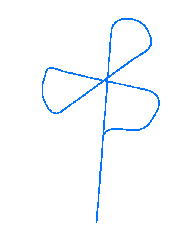

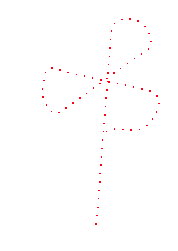

In [ ]:
flight_day = FLIGHT_DAY_SEPTEMBER
flight_num = 0
spike_rate_resolution = RES_MEDIUM
distance = 10
base_round_num = 0

points = get_points(flight_day, flight_num, spike_rate_resolution)
start_frames, end_frames = get_round_start_end(flight_day, spike_rate_resolution, flight_num)

fig = plt.figure(figsize=(PAGE_WIDTH * 0.4, 3))
fig.subplots_adjust(bottom=0, top=1, left=0, right=1)
ax = fig.add_subplot(111)

draw_mean_points(points[start_frames[0] : end_frames[0]], ax, color_value=0.6)

path = Utils.get_path(latex_image_path, 'spike_rate_length_correction_round.png')
fig.savefig(path, dpi=300)

ordered_points, mean_points, ordered_neuro = create_mean_parts(distance, points, flight_day, flight_num,
                                                               spike_rate_resolution)
base_round_points, base_round_mean, base_round_neuro = get_base_round(base_round_num, start_frames, end_frames,
                                                                      ordered_points, mean_points, ordered_neuro)

fig = plt.figure(figsize=(PAGE_WIDTH * 0.4, 3))
ax = fig.add_subplot(111)

# do not show return path to avoid overlaying points
draw_mean_points(base_round_mean[: - 11], ax)

fig.subplots_adjust(bottom=0, top=1, left=0, right=1)

path = Utils.get_path(latex_image_path, 'spike_rate_length_correction_mean_points.png')
fig.savefig(path, dpi=300)

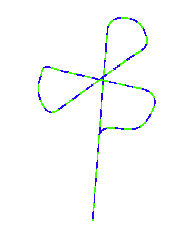

In [ ]:
matched_round_points, matched_round_neuro_data = match_rounds(flight_day, spike_rate_resolution, flight_num,
                                                              start_frames, end_frames, points, base_round_mean)

fig = plt.figure(figsize=(PAGE_WIDTH * 0.4, 3))
ax = fig.add_subplot(111)

# do not show return path to avoid overlaying points
draw_round_points(matched_round_points[1][ : -11], ax)

fig.subplots_adjust(bottom=0, top=1, left=0, right=1)

path = Utils.get_path(latex_image_path, 'spike_rate_length_correction_matched_points.png')
fig.savefig(path, dpi=300)

In [ ]:
def get_length_corrected_swc(flight_day, spike_rate_resolution, flight_num, base_round_num, distance,
                                         min_frame_number, max_frame_number, highlight_margin, lines_only=False):
    
    points = get_points(flight_day, flight_num, spike_rate_resolution, lines_only=lines_only)
    
    start_frames, end_frames = get_round_start_end(flight_day, spike_rate_resolution, flight_num, min_frame_number,
                                                   max_frame_number, lines_only=lines_only)
    
    ordered_points, mean_points, ordered_neuro = create_mean_parts(distance, points, flight_day, flight_num,
                                                               spike_rate_resolution, lines_only=lines_only)
    
    base_round_points, base_round_mean, base_round_neuro = get_base_round(base_round_num, start_frames, end_frames,
                                                                          ordered_points, mean_points,
                                                                          ordered_neuro)
        
    matched_round_points, matched_round_neuro_data = match_rounds(flight_day, spike_rate_resolution, flight_num,
                                                                  start_frames, end_frames, points,
                                                                  base_round_mean, lines_only=lines_only)

    matched_round_neuro_data = mean_bins(matched_round_neuro_data)
    base_round_neuro = mean_bins([base_round_neuro])[0]
    
    added_zeros = 2
    highlight_position = 0
    highlight = []
    rounds = [0 for i in range(added_zeros)]
    
    for i in range(len(matched_round_neuro_data)):        
        rounds.extend(matched_round_neuro_data[i][:60])
        
        highlight.append((highlight_position * distance) - highlight_margin)
        highlight.append((highlight_position * distance) + highlight_margin)
                         
        highlight_position += len(matched_round_neuro_data[i][:60])

    rounds.extend([0 for i in range(added_zeros)])

    base_round_start = len(base_round_neuro[:60]) * (base_round_num)
    base_round_end = len(base_round_neuro[:60]) * (base_round_num + 1)
    corrs = Correlation.swc(rounds, base_round_start, base_round_end)
    
    return corrs, highlight

def get_length_corrected_round_start_highlights(flight_day, spike_rate_resolution, flight_num, min_frame_number,
                                                margin):
    highlight = []
    scale = get_scale_to_seconds(spike_rate_resolution)
    flight_start_rounds, _ = get_round_start_end(flight_day, spike_rate_resolution, flight_num, min_frame_number)

    for start_round in flight_start_rounds:
        highlight.append(((start_round - flight_start_rounds[0]) // scale) - margin)
        highlight.append(((start_round - flight_start_rounds[0]) // scale) + margin)
        
    return highlight

def plot_length_corrected_swcs(spike_rate_resolution, get_autocorrelations, get_highlights, size, use_pgf = False,
                               file_name = None, lines_only=False, use_distance_label=False):
    
    all_flights = 4 + 2
    fig = plt.figure(figsize=(PAGE_WIDTH, all_flights * 1.2)) 
    ax_num = 1
    
    labels = ["Round {}".format(i + 1) for i in range(5)]
    
    for flight_day in range(2):
        flight_count = len(start_rounds[flight_day])
        
        ax = None

        for flight_num in range(flight_count):
            if ax is None:
                ax = fig.add_subplot(all_flights, 1, ax_num)
            else:
                ax = fig.add_subplot(all_flights, 1, ax_num, sharex=ax, sharey=ax)
                
            ax_num += 1

            corrs = []
            highlight = None
            
            min_frame_number = -1
            if flight_day == FLIGHT_DAY_AUGUST:
                min_frame_number = 2000 if flight_num == 1 else 4000
            
            i = 0
            for round_num in range(len(start_rounds[flight_day][flight_num])):                
                max_frame_number = -1
                
                # exclude last round of last flight in September (flight route not finished)
                if flight_day == FLIGHT_DAY_SEPTEMBER and flight_num == 3:
                    max_frame_number = end_rounds[FLIGHT_DAY_SEPTEMBER][3][2] + 50
                
                corr, highlight_areas = get_autocorrelations(flight_day, spike_rate_resolution, flight_num,
                                                             round_num, size, min_frame_number, max_frame_number,
                                                             highlight_margin=5, lines_only=lines_only)
                
                corrs.append(corr)
                
                #if highlight is None:
                if flight_day == FLIGHT_DAY_AUGUST and i == 0 or flight_day == FLIGHT_DAY_SEPTEMBER and i == 1:
                    highlight = highlight_areas
                    
                i += 1
            
            x = [np.arange(0, len(corrs[i]) * size, step=size) for i in range(len(corrs))]
            
            labels_axis = labels if flight_day == 0 and flight_num == 1 else None
            
            corrs = [np.nan_to_num(corrs[i]) for i in range(len(corrs))]
            
            plot(ax, corrs, labels = labels_axis, highlight_regions=highlight, smoothness = 1, x_values=x,
                linewidth = 1)
            
            if flight_day == 0 and flight_num == 1:
                plt.legend(bbox_to_anchor=(-0.15, 2.5, 1.26, 1), loc="lower left", mode="expand", borderaxespad=0,
                           ncol=5, fontsize = FONT_SIZE_LABEL, handlelength=1.0)
                
            bbox=plt.gca().get_position()
            offset = 0.03
            plt.gca().set_position([bbox.x0, bbox.y0 + offset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
                
            if flight_day == 1:
                bbox=plt.gca().get_position()
                offset = -0.05
                plt.gca().set_position([bbox.x0, bbox.y0 + offset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
                
            ax.get_xaxis().set_visible(False)
        ax.get_xaxis().set_visible(True)
            
    
    fig.text(0.98, 0.855, '(a)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.722, '(b)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.55, '(c)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.415, '(d)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.285, '(e)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.16, '(f)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    label = 'distance [m]' if use_distance_label else 'time [s]'
    fig.text(0.5, 0.04, label, ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.02, 0.5, 'pearson correlation', ha='center', va='center', rotation='vertical',
             fontsize = FONT_SIZE_LABEL)
    
    fig.set_facecolor("w")
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.plot()

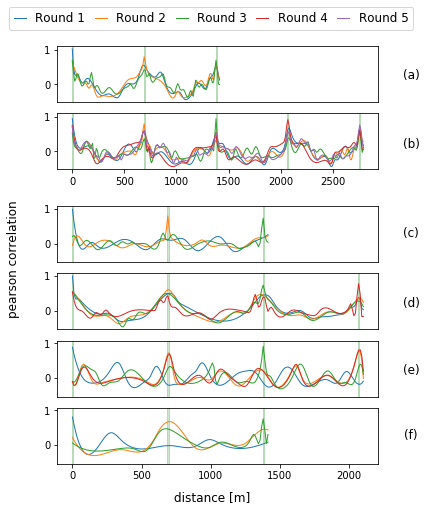

In [ ]:
plot_length_corrected_swcs(RES_MEDIUM, get_length_corrected_swc, et_length_corrected_round_start_highlights,
                           size = 11.5)

In [ ]:
plot_length_corrected_swcs(RES_MEDIUM, get_length_corrected_swc, get_length_corrected_round_start_highlights,
                           size = 11.5, use_pgf = True,
                           file_name = "spike_rate_length_correction_autocorrelation.pgf")

__Plots with only flight lines, without turns (not shown in thesis):__

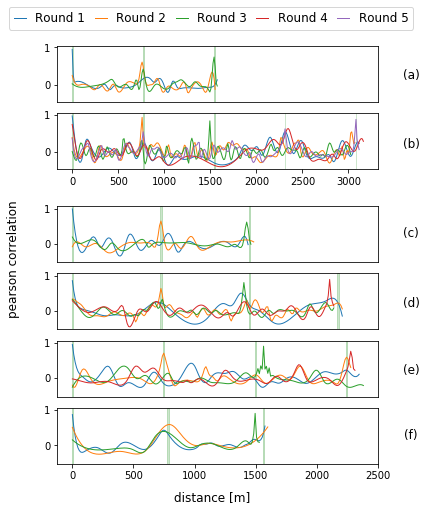

In [ ]:
plot_length_corrected_swcs(RES_MEDIUM, get_length_corrected_swc, get_length_corrected_round_start_highlights,
                           size = 11.5, lines_only=True)

### Presentation

In [ ]:
def plot_length_corrected_swcs_presentation(spike_rate_resolution, get_autocorrelations, get_highlights, size,
                                            use_pgf = False, file_name = None, lines_only=False,
                                            use_distance_label=False):
    all_flights = 4 + 2
    #fig = plt.figure(figsize=(15, all_flights * 3)) 
    fig = plt.figure(figsize=(PAGE_WIDTH, all_flights * 2.5)) 
    ax_num = 1
    
    labels = ["Round {}".format(i + 1) for i in range(5)]
    
    for flight_day in range(2):
        flight_count = len(start_rounds[flight_day])
        
        ax = None

        for flight_num in range(flight_count):
            if ax is None:
                ax = fig.add_subplot(all_flights, 1, ax_num)
            else:
                ax = fig.add_subplot(all_flights, 1, ax_num, sharex=ax, sharey=ax)
                
            ax_num += 1

            corrs = []
            highlight = None
            
            min_frame_number = -1
            if flight_day == FLIGHT_DAY_AUGUST:
                min_frame_number = 2000 if flight_num == 1 else 4000
            
            i = 0
            for round_num in range(len(start_rounds[flight_day][flight_num])):                
                max_frame_number = -1
                
                # exclude last round of last flight in September (flight route not finished)
                if flight_day == FLIGHT_DAY_SEPTEMBER and flight_num == 3:
                    max_frame_number = end_rounds[FLIGHT_DAY_SEPTEMBER][3][2] + 50
                
                corr, highlight_areas = get_autocorrelations(flight_day, spike_rate_resolution, flight_num,
                                                             round_num, size, min_frame_number, max_frame_number,
                                                             highlight_margin=5, lines_only=lines_only)
                
                corrs.append(corr)
                
                if flight_day == FLIGHT_DAY_AUGUST and i == 0 or flight_day == FLIGHT_DAY_SEPTEMBER and i == 1:
                    highlight = highlight_areas
                    
                i += 1
            
            x = [np.arange(0, len(corrs[i]) * size, step=size) for i in range(len(corrs))]
            
            labels_axis = labels if flight_day == 0 and flight_num == 1 else None
            
            corrs = [np.nan_to_num(corrs[i]) for i in range(len(corrs))]
            
            plot(ax, corrs, labels = labels_axis, highlight_regions=highlight, smoothness = 1, x_values=x,
                linewidth = 1)
            
            if flight_day == 0 and flight_num == 1:
                plt.legend(bbox_to_anchor=(-0.15, 2.4, 1.26, 1), loc="lower left", mode="expand", borderaxespad=0,
                           ncol=5, fontsize = FONT_SIZE_LABEL, handlelength=1.0)
                
            if flight_day == FLIGHT_DAY_AUGUST and flight_num == 1 or \
                flight_day == FLIGHT_DAY_SEPTEMBER and flight_num > 1:
                    
                ax.get_yaxis().set_visible(False)
                
            if flight_day == FLIGHT_DAY_SEPTEMBER and flight_num in [0, 2]:
                ax.get_xaxis().set_visible(False)
            
    
    fig.text(0.98, 0.855, '(a)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.722, '(b)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.55, '(c)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.415, '(d)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.285, '(e)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.16, '(f)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    fig.text(0.5, 0.04, 'Distanz [m]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.02, 0.5, 'Korrelation', ha='center', va='center', rotation='vertical', fontsize = FONT_SIZE_LABEL)
    
    fig.set_facecolor("w")
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.plot()

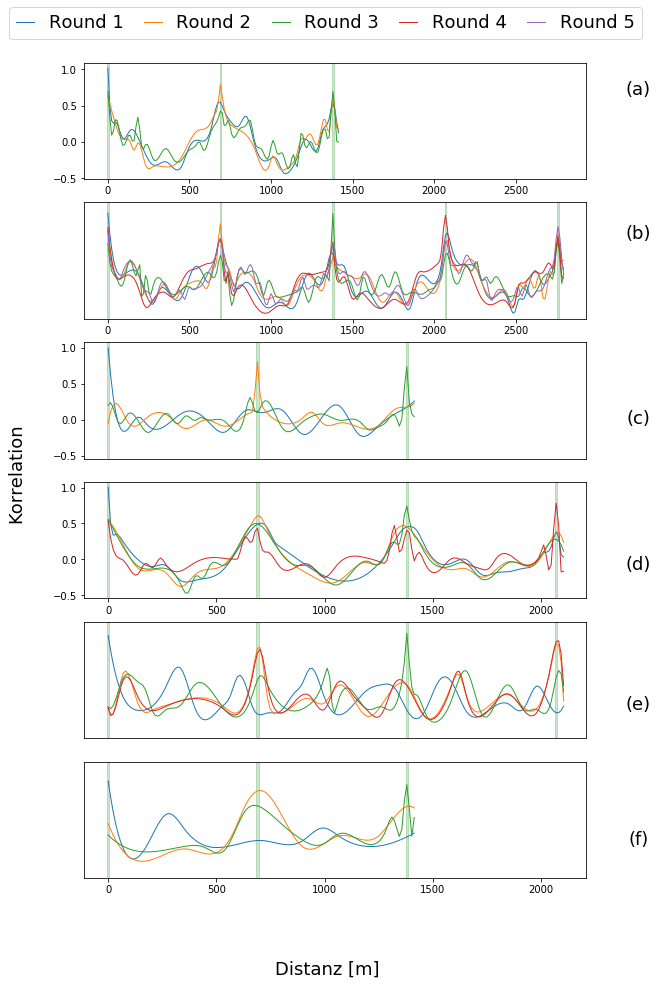

In [ ]:
plot_length_corrected_swcs_presentation(RES_MEDIUM, get_length_corrected_swc,
                                        get_length_corrected_round_start_highlights, size = 11.5,
                                        file_name = "spike_rate_length_correction_autocorrelation.png")

## DTW

In [ ]:
# modified version of dtaidistance.dtw.warping_paths()
def plot_warpingpaths(s1, s2, paths, path=None, filename=None, shownumbers=False):
    """Plot the warping paths matrix.
    :param s1: Series 1
    :param s2: Series 2
    :param paths: Warping paths matrix
    :param path: Path to draw (typically this is the best path)
    :param filename: Filename for the image (optional)
    :param shownumbers: Show distances also as numbers
    """
    
    s_linewidth = 0.5
    s_markersize = 2
    
    path_linewidth = 0.5
    path_markersize = 2
    
    from matplotlib import pyplot as plt
    from matplotlib import gridspec
    from matplotlib.ticker import FuncFormatter

    ratio = max(len(s1), len(s2))
    min_y = min(np.min(s1), np.min(s2))
    max_y = max(np.max(s1), np.max(s2))

    fig = plt.figure(figsize=(PAGE_WIDTH * 0.7, PAGE_WIDTH * 0.7), frameon=True)
    gs = gridspec.GridSpec(2, 2, wspace=1, hspace=1,
                           left=0, right=1.0, bottom=0, top=1.0,
                           height_ratios=[1, 6],
                           width_ratios=[1, 6])
    max_s2_x = np.max(s2)
    max_s2_y = len(s2)
    max_s1_x = np.max(s1)
    min_s1_x = np.min(s1)
    max_s1_y = len(s1)

    if path is None:
        p = dtw.best_path(paths)
    else:
        p = path

    def format_fn2_x(tick_val, tick_pos):
        return max_s2_x - tick_val

    def format_fn2_y(tick_val, tick_pos):
        return int(max_s2_y - tick_val)

    ax0 = fig.add_subplot(gs[0, 0])
    ax0.set_axis_off()
    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())

    ax1 = fig.add_subplot(gs[0, 1:])
    ax1.set_ylim([min_y, max_y])
    ax1.set_axis_off()
    ax1.xaxis.tick_top()
    ax1.plot(range(len(s2)), s2, ".-", linewidth=s_linewidth, markersize=s_markersize)
    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())

    ax2 = fig.add_subplot(gs[1:, 0])
    ax2.set_xlim([-max_y, -min_y])
    ax2.set_axis_off()
    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.plot(-s1, range(max_s1_y, 0, -1), ".-", linewidth=s_linewidth, markersize=s_markersize)

    ax3 = fig.add_subplot(gs[1:, 1:])
    im = ax3.matshow(paths[1:, 1:])
    py, px = zip(*p)
    ax3.plot(px, py, ".-", color="red", linewidth=path_linewidth, markersize=path_markersize)
    if shownumbers:
        for r in range(1, paths.shape[0]):
            for c in range(1, paths.shape[1]):
                ax3.text(c - 1, r - 1, "{:.2f}".format(paths[r, c]))

    gs.tight_layout(fig, pad=1.0, h_pad=1.0, w_pad=1.0, rect=(0, 0, 0.95, 0.95))

    ax = fig.axes

    if filename:
        if type(filename) != str:
            filename = str(filename)
        plt.savefig(filename)
        plt.close()
        fig, ax = None, None
    return fig, ax, im

In [ ]:
def show_warping_spike_rate(flight_day, spike_rate_resolution, flight_num, round_num_1,
                            round_num_2, window_size = -1, use_pgf = False, file_names = None):
    
    spike_rate, _, flight_start_rounds, last_round_end = get_data_wihout_waitings(flight_day,
                                                                                  spike_rate_resolution,
                                                                                  flight_num)
    
    round_1 = spike_rate[flight_start_rounds[round_num_1] : flight_start_rounds[round_num_1 + 1]]
    round_2 = spike_rate[flight_start_rounds[round_num_2] : flight_start_rounds[round_num_2 + 1] if
                         len(flight_start_rounds) > round_num_2 + 1 else last_round_end]

    fig, ax = Dtw.show_warping(round_1, round_2, window_size, fig_width = PAGE_WIDTH, fig_height = 3.5)
    
    fig.text(0.98, 0.7, '(a)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.3, '(b)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    fig.text(0.5, 0.02, 'time [s]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.02, 0.5, 'spike rate [Hz]', ha='center', va='center', rotation='vertical',
             fontsize = FONT_SIZE_LABEL)
    
        
    s1, s2, paths, best_path = Dtw.show_dtw_path(round_1, round_2, window_size = window_size, mode = 3)
    fig2, ax2, im2 = plot_warpingpaths(s1, s2, paths, best_path)
    
    # show colorbar next to matrix
    divider = make_axes_locatable(ax2[3])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    plt.colorbar(im2, cax=cax, orientation='vertical')
    
    # create invisible axis with same with as colorbar next to upper time series such that the series and matrix
    # have the same width
    divider = make_axes_locatable(ax2[1])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cax.set_visible(False)
    
    if use_pgf:
        backend_pgf(fig, file_names[0])
        backend_pgf(fig2, file_names[1])
    else:
        backend_inline(fig, file_names[0] if file_names is not None else None)
        backend_inline(fig2, file_names[1] if file_names is not None else None)
        plt.plot()

In [ ]:
file_names = ['spike_rate_dtw_warping.png', 'spike_rate_dtw_matrix.png']
        
show_warping_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_HIGH, flight_num = 1, round_num_1 = 0, round_num_2 = 1,
                       window_size = 10, use_pgf = False, file_names = file_names)
        
file_names = ['spike_rate_dtw_warping.pgf', 'spike_rate_dtw_matrix.pgf']
        
show_warping_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_HIGH, flight_num = 1, round_num_1 = 0, round_num_2 = 1,
                       window_size = 10, use_pgf = True, file_names = file_names)

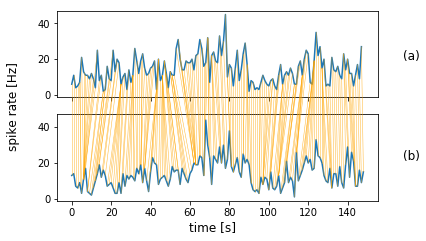

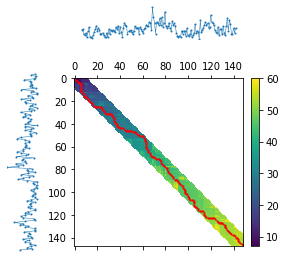

In [ ]:
show_warping_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_HIGH, flight_num = 1, round_num_1 = 0, round_num_2 = 1,
                       window_size = 10)

In [ ]:
import dtaidistance.dtw

def get_dtw_autocorrelations(flight_day, spike_rate_resolution, flight_num, base_round_num, window_size,
                                         min_frame_number, max_frame_number, highlight_margin, lines_only=False):
    
    distance = 0.5
    
    points = get_points(flight_day, flight_num, spike_rate_resolution, lines_only=lines_only)
    
    start_frames, end_frames = get_round_start_end(flight_day, spike_rate_resolution, flight_num, min_frame_number,
                                                   max_frame_number, lines_only=lines_only)
    
    ordered_points, mean_points, ordered_neuro = create_mean_parts(distance, points, flight_day, flight_num,
                                                               spike_rate_resolution, lines_only=lines_only)
    
    base_round_points, base_round_mean, base_round_neuro = get_base_round(base_round_num, start_frames, end_frames,
                                                                          ordered_points, mean_points,
                                                                          ordered_neuro)
        
    matched_round_points, matched_round_neuro_data = match_rounds(flight_day, spike_rate_resolution, flight_num,
                                                                  start_frames, end_frames, points,
                                                                  base_round_mean, lines_only=lines_only)
    
    matched_round_neuro_data = mean_bins(matched_round_neuro_data)
    base_round_neuro = mean_bins([base_round_neuro])[0]
    
    
    added_zeros = 2
    highlight_position = 0
    highlight = [1,50]
    
    # padding before first round
    rounds = [0 for i in range(added_zeros)]
    
    highlight_position = 0
    highlight = []
    rounds = [0 for i in range(added_zeros)]
    
    scale = get_scale_to_seconds(spike_rate_resolution)
    
    for i in range(len(matched_round_neuro_data)):        
        warp_round = matched_round_neuro_data[i]        
        
        # warp length corrected round to base round        
        assignments = dtaidistance.dtw.warp(warp_round, base_round_neuro, window = 10)[0]
        assignments_mean = get_bin_data(assignments, bin_size = window_size)
        
        rounds.extend(assignments_mean)
        
        highlight.append((highlight_position // scale) - highlight_margin)
        highlight.append((highlight_position // scale) + highlight_margin)
                         
        highlight_position += len(matched_round_neuro_data[i])
        
        
    # padding after last round
    rounds.extend([0 for i in range(added_zeros)])
    
    base_round_start = (len(base_round_neuro) // window_size) * base_round_num
    base_round_end = (len(base_round_neuro) // window_size) * (base_round_num + 1)
    corrs = Correlation.swc(rounds, base_round_start, base_round_end)
    
    return corrs, highlight


def plot_length_corrected_autocorrelations(spike_rate_resolution, get_autocorrelations, get_highlights, size,
                                           use_pgf = False, file_name = None, lines_only=False,
                                           use_distance_label=False):
    all_flights = 4 + 2
    fig = plt.figure(figsize=(PAGE_WIDTH, all_flights * 1.2)) 
    ax_num = 1
    
    labels = ["Round {}".format(i + 1) for i in range(5)]
    
    for flight_day in range(2):
        flight_count = len(start_rounds[flight_day])
        
        ax = None

        for flight_num in range(flight_count):
            if ax is None:
                ax = fig.add_subplot(all_flights, 1, ax_num)
            else:
                ax = fig.add_subplot(all_flights, 1, ax_num, sharex=ax, sharey=ax)
                
            ax_num += 1

            corrs = []
            highlight = None
            
            min_frame_number = -1
            if flight_day == FLIGHT_DAY_AUGUST:
                min_frame_number = 2000 if flight_num == 1 else 4000
            
            i = 0
            for round_num in range(len(start_rounds[flight_day][flight_num])):                
                max_frame_number = -1
                
                # exclude last round of last flight in September (flight route not finished)
                if flight_day == FLIGHT_DAY_SEPTEMBER and flight_num == 3:
                    max_frame_number = end_rounds[FLIGHT_DAY_SEPTEMBER][3][2] + 50
                
                corr, highlight_areas = get_autocorrelations(flight_day, spike_rate_resolution, flight_num,
                                                             round_num, size, min_frame_number, max_frame_number,
                                                             highlight_margin=1, lines_only=lines_only)
                
                corrs.append(corr)
                
                #if highlight is None:
                if flight_day == FLIGHT_DAY_AUGUST and i == 0 or flight_day == FLIGHT_DAY_SEPTEMBER and i == 1:
                    highlight = highlight_areas
                    
                i += 1
            
            x = [get_x_values_in_seconds(corrs[i], spike_rate_resolution, size) for i in range(len(corrs))]
            
            labels_axis = labels if flight_day == 0 and flight_num == 1 else None
            
            corrs = [np.nan_to_num(corrs[i]) for i in range(len(corrs))]
            
            plot(ax, corrs, labels = labels_axis, highlight_regions=highlight, smoothness = 1, x_values=x,
                linewidth = 1)
            
            if flight_day == 0 and flight_num == 1:
                plt.legend(bbox_to_anchor=(-0.15, 2.5, 1.26, 1), loc="lower left", mode="expand", borderaxespad=0,
                           ncol=5, fontsize = FONT_SIZE_LABEL, handlelength=1.0)
                
            bbox=plt.gca().get_position()
            offset = 0.03
            plt.gca().set_position([bbox.x0, bbox.y0 + offset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
                
            if flight_day == 1:
                bbox=plt.gca().get_position()
                offset = -0.05
                plt.gca().set_position([bbox.x0, bbox.y0 + offset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
                
            ax.get_xaxis().set_visible(False)
        ax.get_xaxis().set_visible(True)
            
    
    fig.text(0.98, 0.855, '(a)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.722, '(b)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.55, '(c)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.415, '(d)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.285, '(e)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.16, '(f)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    label = 'distance [m]' if use_distance_label else 'time [s]'
    fig.text(0.5, 0.04, label, ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.02, 0.5, 'pearson correlation', ha='center', va='center', rotation='vertical',
             fontsize = FONT_SIZE_LABEL)
    
    fig.set_facecolor("w")
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.plot()

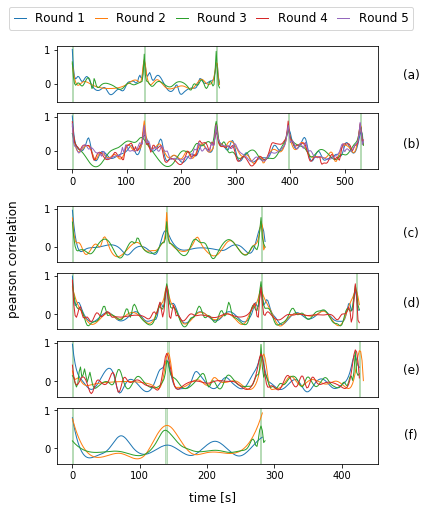

In [ ]:
plot_length_corrected_autocorrelations(RES_MEDIUM, get_dtw_autocorrelations,
                                       None, size=20)

In [ ]:
plot_length_corrected_autocorrelations(RES_MEDIUM, get_dtw_autocorrelations,
                                       None, size=20, use_pgf = True,
                                      file_name = 'spike_rate_dtw_autocorrelation.pgf')

__Plots with only flight lines, without turns (not shown in thesis):__

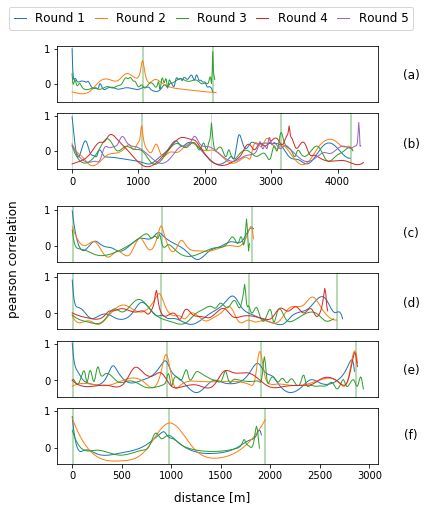

In [ ]:
plot_length_corrected_autocorrelations(RES_MEDIUM, get_dtw_autocorrelations,
                                       None, size=10, lines_only=True)

# Chapter 5: Autoencoder

In [ ]:
mask_path = Utils.get_path(["05_mapping"], "compressed_mask.png")
compressed_mask = imread(mask_path)

ae_model_path = Utils.get_path(["02_autoencoder"], "model_september.pt")
bee_view_image_path = Utils.get_path(["flights", "flight_2018_09_03#1", "bee_eye_september_model"])

batch_size = 128

model_loader = ModelLoader(Autoencoder, ae_model_path, bee_view_image_path, batch_size = batch_size,
                           image_height = int(262 // 4.05), image_width = int(226 // 4.05))

bee_view_image_path = Utils.get_path(["flights", "flight_2018_09_03#2", "bee_eye"])
model_loader_2 = ModelLoader(Autoencoder, ae_model_path, bee_view_image_path, batch_size = batch_size,
                           image_height = int(262 // 4.05), image_width = int(226 // 4.05))

In [ ]:
def get_round_correlations(model_loader, flight_num, round_num, window_size = -1, dummy = False):
    start = get_start_round(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, flight_num, round_num)
    end = get_end_round(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, flight_num, round_num)
    
    if dummy:
        corr_count = (end - start)
        
        if window_size > 0:
            corr_count = corr_count // 20
        
        corrs = []
        for i in range(corr_count):
            corr = Correlation.Correlation(-1, -1, -1, -1, -1)
            corr.pearson = random.uniform(-1, 1)
            
            corrs.append(corr)
            
        return corrs
    
    activations = DataLoader.load_activations(model_loader, start, end)
    spike_rate = get_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num)[start : end]
    
    return Correlation.correlate(activations, spike_rate, window_size = window_size)

def get_corr_locations(corrs, count = -1):
    image_height = 64
    image_width = 55
    
    if count > 0:
        corrs = corrs[ : count]
        
    corr_image = np.zeros((image_height, image_width))
    
    conv_layers = np.arange(0, 17, step=2)
    conv_scale_layers = [2, 6, 10, 14]
    
    for corr in corrs:
        row = corr.row
        col = corr.col
        size = 0
        
        for layer_num in range(corr.layer, -1, -1):
            if layer_num in conv_scale_layers:
                row *= 2
                col *= 2
                size *= 2
            
            if layer_num in conv_layers:
                size += 1
        
        row_start = max(0, row - size)
        row_end = min(image_height - 1, row + size + 1)
        
        col_start = max(0, col - size)
        col_end = min(image_width - 1, col + size + 1)
        
        corr_image[row_start : row_end, col_start : col_end] += 1
    
    corr_image = corr_image / len(corrs) * 100
    
    return corr_image    

__Structure of the encoder part of the autencoder and the sum of all the encoder's activations:__

In [ ]:
round_corrs = get_round_correlations(model_loader, flight_num = 0, round_num = 0)

last_corr = None
activation_map_count = 0
activation_count = 0
activation_count_per_map = 0

for corr in round_corrs:    
    if corr.filter_num == 0 and activation_map_count > 0:
        activation_count += (activation_map_count + 1) * activation_count_per_map
        
        print("Activation maps: ", activation_map_count + 1)
        activation_map_count = 0
    
    if corr.filter_num != 0:
        activation_map_count = corr.filter_num
        
        if last_corr is not None:
            activation_count_per_map = (last_corr.row + 1) * (last_corr.col + 1)
            
            print("Layer {}: {} x {}".format(last_corr.layer, last_corr.row + 1, last_corr.col + 1))
            last_corr = None
        
        continue
    
    last_corr = corr
    
print("Activation maps: ", activation_map_count + 1)
    
activation_count += (activation_map_count + 1) * activation_count_per_map
print("Activations: ", activation_count)

Layer 0: 64 x 55
Activation maps:  8
Layer 1: 64 x 55
Activation maps:  8
Layer 2: 32 x 28
Activation maps:  8
Layer 3: 32 x 28
Activation maps:  8
Layer 4: 32 x 28
Activation maps:  16
Layer 5: 32 x 28
Activation maps:  16
Layer 6: 16 x 14
Activation maps:  16
Layer 7: 16 x 14
Activation maps:  16
Layer 8: 16 x 14
Activation maps:  32
Layer 9: 16 x 14
Activation maps:  32
Layer 10: 8 x 7
Activation maps:  32
Layer 11: 8 x 7
Activation maps:  32
Layer 12: 8 x 7
Activation maps:  64
Layer 13: 8 x 7
Activation maps:  64
Layer 14: 4 x 4
Activation maps:  64
Layer 15: 4 x 4
Activation maps:  64
Layer 16: 4 x 4
Activation maps:  128
Layer 17: 4 x 4
Activation maps:  128
Activations:  137728


## Save Activation Maps (Presentation)

__Save one activation map of each layer for all frames. This is used in a video during presentation.__

In [ ]:
import sys
import time

current_milli_time = lambda: int(round(time.time() * 1000))

def save_activations(path, model_loader, activation_map_num=0, frame_num_start=-1, frame_num_end=-1, layers=None):
    if layers is None:
        layers = np.arange(len(model_loader.model.encoder))
    
    # create sub-directories
    for layer_num in layers:
        layer_path = os.path.join(path, "activation_layer_" + str(layer_num), "")
        
        if not os.path.exists(layer_path):
            os.makedirs(layer_path)
    
    for i_batch, (xb, yb) in enumerate(model_loader.data_loader):
        a = current_milli_time()
        
        if (i_batch + 1) * model_loader.batch_size < frame_num_start:
            continue
            
        if frame_num_end > 0 and i_batch * model_loader.batch_size > frame_num_end:
            break
        
        xbd = xb.data
        
        with torch.no_grad():
            model_loader.model.eval()

            xr = xbd.to(model_loader.device)
            
            for ii, layer in enumerate(model_loader.model.encoder):
                b = current_milli_time()
                
                xr = layer(xr)
                
                if ii in layers:
                    layer_path = os.path.join(path, "activation_layer_" + str(ii), "")
                    
                    fig = plt.figure(frameon=False, figsize=(2, 2))
                    ax = plt.Axes(fig, [0., 0., 1., 1.])
                    fig.add_axes(ax)
                    
                    for img_num in range(batch_size):
                        img = xr[img_num, activation_map_num].cpu().data.numpy()
                        
                        ax.clear()
                        ax.set_axis_off()
                        ax.imshow(img)
                        
                        ax.xaxis.set_visible(False)
                        ax.yaxis.set_visible(False)
                        
                        fig.savefig(layer_path + str((i_batch * model_loader.batch_size) + img_num) + ".png",
                                    bbox_inches='tight', pad_inches=0)
                        
                    plt.close(fig)
                
                if ii > layers[-1]:
                    break
                    
        sys.stdout.write("\rBatch: {}".format(i_batch))

In [ ]:
activation_path = Utils.get_path(["07_thesis_figures", "presentation", "activations"], "")
save_activations(activation_path, model_loader, activation_map_num=0, frame_num_start=630, frame_num_end=1921,
                 layers=[0,2,4,6,8,10,12,14,16])

Batch: 15

## Plot an activation and brain activity during one round (Presentation)

In [ ]:
def show_activation_and_spike_rate(flight_num, round_num):
    start = get_start_round(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, flight_num, round_num)
    end = get_end_round(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, flight_num, round_num)
    
    activations = DataLoader.load_activations(model_loader, start, end)
    spike_rate = get_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num)[start : end]
    
    fig = plt.figure(figsize=(PAGE_WIDTH, 1.7))
    ax = fig.add_subplot(111)
    
    x = get_x_values_in_seconds(spike_rate, RES_MEDIUM)    
    ax.plot(x, spike_rate, 'k-')
    
    backend_inline(fig, "ae_corr_spike_rate.png")
    plt.show()
    
    fig = plt.figure(figsize=(PAGE_WIDTH, 1.7))
    ax = fig.add_subplot(111)
    
    x = get_x_values_in_seconds(activations[0][0][30][40], RES_MEDIUM)    
    ax.plot(x, activations[0][0][30][40])
    
    backend_inline(fig, "ae_corr_activation.png")
    plt.show()

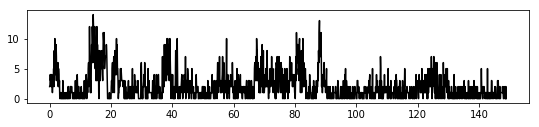

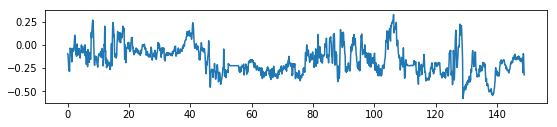

In [ ]:
show_activation_and_spike_rate(flight_num=0, round_num=0)

## Training

In [ ]:
def plot_loss(use_pgf=False, file_name=None):
    batch_size = 128

    h, w = 262 // 4.05, 226 // 4.05
    h = int(h)
    w = int(w)

    path_training = Utils.get_path(['02_autoencoder', 'training_data_september'])
    valid_size = .8

    train_loader, valid_loader = DataLoader.load_training_data(h, w, path_training, valid_size, batch_size)

    batches_per_epoch = np.floor(len(train_loader.sampler.indices) / batch_size)
    
    path = Utils.get_path(['02_autoencoder'], 'model_september.pt')

    losses = Utils.load_object(path + "losses.dill")
    val_losses = Utils.load_object(path + "val_losses.dill")
    
    fig = plt.figure(figsize=(PAGE_WIDTH, 2.5))
    fig.subplots_adjust(left=0.15,bottom=0.25, right=0.8)

    ax = fig.add_subplot(111)

    ax.plot(pd.Series(losses[int(batches_per_epoch):]).rolling(100).mean(), label="training loss")
    ax.plot(np.arange(len(val_losses) - 1) * batches_per_epoch, val_losses[1:], label="validation loss")
    
    ax.legend(loc='upper right', fontsize=FONT_SIZE_LABEL)
    
    fig.text(0.47, 0.02, 'number of batches', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.02, 0.55, 'loss', ha='center', va='center', rotation='vertical', fontsize = FONT_SIZE_LABEL)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show()

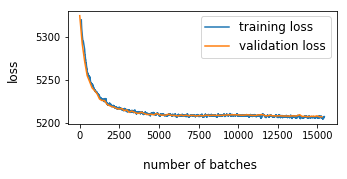

In [ ]:
plot_loss(use_pgf=False, file_name='ae_loss.png')
plot_loss(use_pgf=True, file_name='ae_loss.pgf')

## Round analysis

In [ ]:
def hist3d(corrs, bins = 20, pearson = True, conv_layers_only=False):
    all_corrs = []
    
    if pearson:
        all_corrs = [c.pearson for c in corrs if not math.isnan(c.pearson)]
    else:
        all_corrs = [c.spearman for c in corrs if not math.isnan(c.spearman)]
    
    layers = max([c.layer for c in corrs]) + 1
    
    x_min = min(all_corrs)
    x_max = max(all_corrs)
    y_min = 0
    y_max = layers
    
    x = []
    y = []
    sums = [0 for i in range(layers)]
    for corr in corrs:
        r = corr.pearson if pearson else corr.spearman
        sums[corr.layer] += 1
        
        x.append(r)
        y.append(corr.layer)
        
    fig = plt.figure(figsize=(PAGE_WIDTH, PAGE_WIDTH))
    ax = fig.add_subplot(111, projection='3d')
    hist, xedges, yedges = np.histogram2d(x, y, bins = [bins, layers], range=[[x_min, x_max], [y_min - 0.5, y_max - 0.5]])
    
    # norm:
    for layer in range(layers):
        for bin_num in range(len(hist)):
            hist[bin_num, layer] = hist[bin_num, layer] / sums[layer] * 100
    
    # Construct arrays for the anchor positions of the 16 bars.
    # Note: np.meshgrid gives arrays in (ny, nx) so we use 'F' to flatten xpos,
    # ypos in column-major order. For numpy >= 1.7, we could instead call meshgrid
    # with indexing='ij'.
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1])
    xpos = xpos.flatten('F')
    ypos = ypos.flatten('F')
    zpos = np.zeros_like(xpos)
    
    # Construct arrays with the dimensions for the 16 bars.
    dx = 0.01 * np.ones_like(zpos)
    dy = dx.copy()
    dz = hist.flatten()
    
    color_values = []
    for y_pos in ypos:
        color = plt.cm.jet(y_pos / float(layers))
        color_values.append(color)
    
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=color_values, zsort='average')

    xlabel = 'Korrelation' if conv_layers_only else 'pearson correlation'
    ylabel = 'Layer' if conv_layers_only else 'layer'
    zlabel = 'Relative Anzahl der Aktivierungen [%]' if conv_layers_only else 'relative amount of activations [%]'
    
    ax.set_xlabel(xlabel if pearson else 'spearman correlation', fontsize = FONT_SIZE_LABEL, labelpad=20)
    ax.set_ylabel(ylabel, fontsize = FONT_SIZE_LABEL, labelpad=20)    
    ax.set_zlabel(zlabel, fontsize = FONT_SIZE_LABEL, labelpad=20)
    
    if conv_layers_only:
        ax.yaxis.set_ticks(np.arange(0, 9, 2))
    else:
        ax.yaxis.set_ticks(np.arange(0, 17, 2))
    
    ax.xaxis.set_tick_params(labelsize= FONT_SIZE_LABEL)
    ax.yaxis.set_tick_params(labelsize= FONT_SIZE_LABEL)
    ax.zaxis.set_tick_params(labelsize= FONT_SIZE_LABEL) 
    
    return fig


### Thesis

In [ ]:
def show_histogram_all_rounds(model_loader, flight_num, use_pgf = False, file_name = None):
    corrs = []
    
    for round_num in range(3):
        corr = get_round_correlations(model_loader, flight_num, round_num = round_num)
        corrs.extend(corr)
        
    fig = hist3d(corrs, bins = 45, pearson = True)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show() 

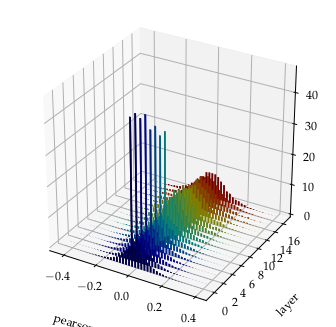

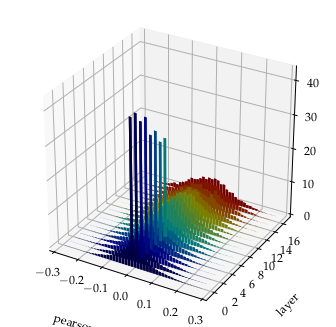

In [ ]:
show_histogram_all_rounds(model_loader, flight_num = 0, use_pgf=True, file_name='ae_histogram_flight_1.pgf')
show_histogram_all_rounds(model_loader, flight_num = 1, use_pgf=True, file_name='ae_histogram_flight_2.pgf')

In [ ]:
def show_activations(frame_num, filter_num = 0, use_pgf = False, file_name = None):
    img_num = frame_num % batch_size
    
    fig = plt.figure(figsize = (PAGE_WIDTH,4.2), facecolor='white')
    
    rows = 6
    cols = 9
    gs = GridSpec(rows, cols, figure=fig)
    
    panorama = plt.imread(Utils.get_path(['07_thesis_figures'], '1600_pinhole.png'))
    ax = fig.add_subplot(gs[0 : 2, 3 : 6])
    ax.imshow(panorama)
    ax.axis('off')
    
    panorama = plt.imread(Utils.get_path(['07_thesis_figures'], '1600_panorama.png'))
    ax = fig.add_subplot(gs[2 : 4, 1 : 5])
    ax.imshow(panorama)
    ax.axis('off')
    
    for i_batch, (xb, yb) in enumerate(model_loader.data_loader):
        if i_batch * batch_size <= frame_num and (i_batch * batch_size) + batch_size > frame_num:
            xbd = xb.data
            xr = xbd.to(model_loader.device)
            
            img = xr[img_num].cpu().data.numpy()
            img = np.transpose(img, (1, 2, 0))
            
            ax = fig.add_subplot(gs[2 : 4, 6 : 8])
            ax.imshow(img)
            ax.axis('off')
            
            
            
            with torch.no_grad():
                model_loader.model.eval()

                for ii, layer in enumerate(model_loader.model.encoder):
                    xr = layer(xr)
                    img = xr[img_num, filter_num].cpu().data.numpy()
                    
                    ax = fig.add_subplot(gs[4 + (ii // 9), ii % 9])
                    ax.imshow(img)
                    ax.axis('off')
            
            break
    
    fig.text(0.33, 0.82, '(a)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.12, 0.49, '(b)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.96, 0.49, '(c)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.02, 0.18, '(d)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    fig.subplots_adjust(bottom=-0.1, top=1.1, right=0.99, left=0.1, wspace = 0.1, hspace = -0.6)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show() 

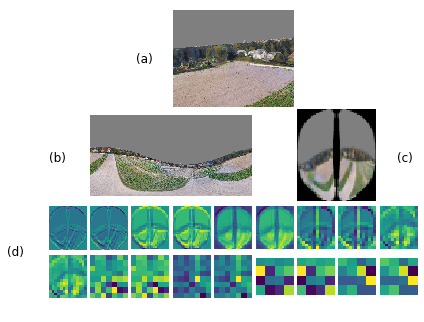

In [ ]:
show_activations(1000, use_pgf=False, file_name='ae_example_activations.png')
show_activations(1000, use_pgf=True, file_name='ae_example_activations.pgf')

In [ ]:
def show_correlations(pearson = True, show_filter_num = 0, use_pgf = False, file_name = None):
    start = get_start_round(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, flight_num = 0, round_num = 0)
    end = get_end_round(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, flight_num = 0, round_num = 0)

    activations = DataLoader.load_activations(model_loader, start, end)
    spike_rate = get_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num = 0)[start : end]
    
    corrs = Correlation.correlate(activations, spike_rate)
    
    current_layer = 0
    current_activation = 0
    current_row_number = 0
    current_row = []
    current_image = []
    correlation_images = []
    
    layer_arrays = []

    max_corr = 0
    min_corr = 0
    if pearson:
        max_corr = max(corrs, key=attrgetter('pearson')).pearson
        min_corr = min(corrs, key=attrgetter('pearson')).pearson
    else:
        # remove nans since max of spearman correlation list with nan returns nan
        corrs_without_nan = [c.spearman for c in corrs if not math.isnan(c.spearman)]
        max_corr = max(corrs_without_nan)
        min_corr = min(corrs_without_nan)
    
    for corr in corrs:
        if current_row_number != corr.row:        
            current_image.append(np.array(current_row))

            current_row_number = corr.row
            current_row.clear()

        if current_activation != corr.filter_num:        
            if current_activation == show_filter_num:
                img = np.array(current_image)
                correlation_images.append(img)

            current_activation = corr.filter_num
            current_image.clear()

        if current_layer != corr.layer:
            current_layer = corr.layer

        corr_value = corr.pearson if pearson else corr.spearman
        
        current_row.append(corr_value)
        
    image_count = len(correlation_images)  
    fig = plt.figure(figsize = (PAGE_WIDTH, 2))
    
    for image_num in range(image_count):
        ax = fig.add_subplot(2, image_count // 2, image_num + 1)
        im = ax.imshow(correlation_images[image_num], vmin = min_corr, vmax = max_corr)
        ax.axis('off')
        
    fig.subplots_adjust(bottom=0.25, top=1, left = 0.05, right = 0.95, hspace = 0)
    
    cbar_ax = fig.add_axes([0.26, 0.15, 0.5, 0.08])
    fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    
    cbar_ax.tick_params(labelsize = FONT_SIZE_LABEL)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show() 

In [ ]:
show_correlations(use_pgf=False, file_name = 'ae_example_correlations.png')
show_correlations(use_pgf=True, file_name = 'ae_example_correlations.pgf')

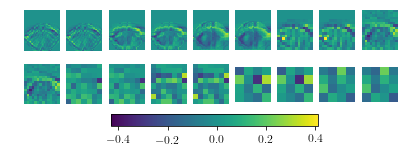

In [ ]:
show_correlations()

In [ ]:
def show_highest_round_correlation_locations(model_loaders, flight_nums, dummy=False, use_pgf=False,
                                             file_name=None):
    
    def add_colorbar(ax, im, count):        
        ax_pos = ax.get_position() 
        left = ax_pos.x0 + ax_pos.width + 0.03
        bottom = ax_pos.y0
        width = 0.03
        height = ax_pos.height
        
        cax = fig.add_axes([left, bottom, width, height])
        cax.tick_params(labelsize = FONT_SIZE_LABEL)
        
        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
        
        if count == 20:
            cbar.set_ticks([0, 30, 60, 90])
            cbar.set_ticklabels(['0 \%', '30 \%', '60 \%', '90 \%'])
        else:
            cbar.set_ticks([0, 10, 20, 30, 40])
            cbar.set_ticklabels(['0 \%', '10 \%', '20 \%', '30 \%', '40 \%'])
            
        
    
    fig = plt.figure(figsize=(PAGE_WIDTH, 6.5))
    
    round_nums = max([len(start_rounds[FLIGHT_DAY_SEPTEMBER][flight_num]) for flight_num in flight_nums])
    
    rows = len(flight_nums) * 2
    cols = round_nums
    
    colorbar_args = []
    
    for current_flight_index in range(len(flight_nums)):
        model_loader = model_loaders[flight_nums[current_flight_index]]
        flight_num = flight_nums[flight_nums[current_flight_index]]
        rounds = len(start_rounds[FLIGHT_DAY_SEPTEMBER][flight_num])
        
        flight_plot_start = current_flight_index * cols * 2
        
        last_images = [None, None]
        
        for round_num in range(rounds):
            round_corrs = get_round_correlations(model_loader, flight_num, round_num = round_num, dummy = dummy)

            round_corrs = sorted(round_corrs, key=attrgetter('pearson'), reverse=True)

            if not dummy:
                print("Highest pearson correlation round {}: {}".format(round_num + 1, round_corrs[0].pearson))

            for count in [20, 5000]:                
                if count == 20:
                    ax = fig.add_subplot(rows, cols, flight_plot_start + round_num + 1)
                    
                    if current_flight_index == 0:
                        ax.set_title("Round {}".format(round_num + 1), fontsize = FONT_SIZE_LABEL, y = 1.1)
                else:
                    ax = fig.add_subplot(rows, cols, flight_plot_start + round_num + 1 + cols)

                corr_image = get_corr_locations(round_corrs, count)
                
                if not dummy:
                    print("    Most used pixel in {} highest correlations has {} hits".format(count,
                                                                                              np.amax(corr_image)))

                vmax = 90 if count == 20 else 40
                im = ax.imshow(corr_image, vmin = 0, vmax = vmax)
                ax.axis('off') 

                if round_num == 3:
                    colorbar_args.append((ax, im, count))
                    
                last_images[0 if count == 20 else 1] = im
        
        if rounds < cols:
            for round_num in range(rounds + 1, cols + 1):
                for count in [20, 5000]:
                    empty = np.full((64, 55), np.nan)

                    current_cmap = matplotlib.cm.get_cmap()
                    current_cmap.set_bad(alpha=0)  

                    if count == 20:
                        ax = fig.add_subplot(rows, cols, flight_plot_start + round_num)
                        
                        if current_flight_index == 0:
                            ax.set_title("Round {}".format(round_num), fontsize = FONT_SIZE_LABEL, y = 1.1)
                    else:
                        ax = fig.add_subplot(rows, cols, flight_plot_start + round_num + cols)
                        
                    vmax = 90 if count == 20 else 40
                    ax.imshow(empty, vmin = 0, vmax = vmax)
                    ax.axis('off')

                    if round_num == cols:
                        colorbar_args.append((ax, last_images[0 if count == 20 else 1], count))
       
   
    fig.text(0.02, 0.82, '(a)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.02, 0.59, '(b)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    fig.text(0.02, 0.35, '(c)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.02, 0.11, '(d)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    fig.subplots_adjust(bottom=0.02, top=0.94, left = 0.06, right = 0.87, hspace=0.1, wspace=0.1)
    
    for ax, im, count in colorbar_args:
        add_colorbar(ax, im, count)
     
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show() 

In [ ]:
show_highest_round_correlation_locations([model_loader, model_loader_2], [0, 1], use_pgf=True,
                                         file_name='ae_hits_rounds.pgf')

Highest pearson correlation round 1: 0.41221446128685546
    Most used pixel in 20 highest correlations has 85.0 hits
    Most used pixel in 5000 highest correlations has 27.0 hits
Highest pearson correlation round 2: 0.3472411896826165
    Most used pixel in 20 highest correlations has 80.0 hits
    Most used pixel in 5000 highest correlations has 38.78 hits
Highest pearson correlation round 3: 0.21584421118688127
    Most used pixel in 20 highest correlations has 55.00000000000001 hits
    Most used pixel in 5000 highest correlations has 19.84 hits
Highest pearson correlation round 1: 0.25334186748322135
    Most used pixel in 20 highest correlations has 65.0 hits
    Most used pixel in 5000 highest correlations has 41.14 hits
Highest pearson correlation round 2: 0.2928643775097538
    Most used pixel in 20 highest correlations has 65.0 hits
    Most used pixel in 5000 highest correlations has 36.36 hits
Highest pearson correlation round 3: 0.21738960840512658
    Most used pixel in 

Highest pearson correlation round 1: 0.41221446128685546
    Most used pixel in 20 highest correlations has 85.0 hits
    Most used pixel in 5000 highest correlations has 27.0 hits
Highest pearson correlation round 2: 0.3472411896826165
    Most used pixel in 20 highest correlations has 80.0 hits
    Most used pixel in 5000 highest correlations has 38.78 hits
Highest pearson correlation round 3: 0.21584421118688127
    Most used pixel in 20 highest correlations has 55.00000000000001 hits
    Most used pixel in 5000 highest correlations has 19.84 hits
Highest pearson correlation round 1: 0.25334186748322135
    Most used pixel in 20 highest correlations has 65.0 hits
    Most used pixel in 5000 highest correlations has 41.14 hits
Highest pearson correlation round 2: 0.2928643775097538
    Most used pixel in 20 highest correlations has 65.0 hits
    Most used pixel in 5000 highest correlations has 36.36 hits
Highest pearson correlation round 3: 0.21738960840512658
    Most used pixel in 

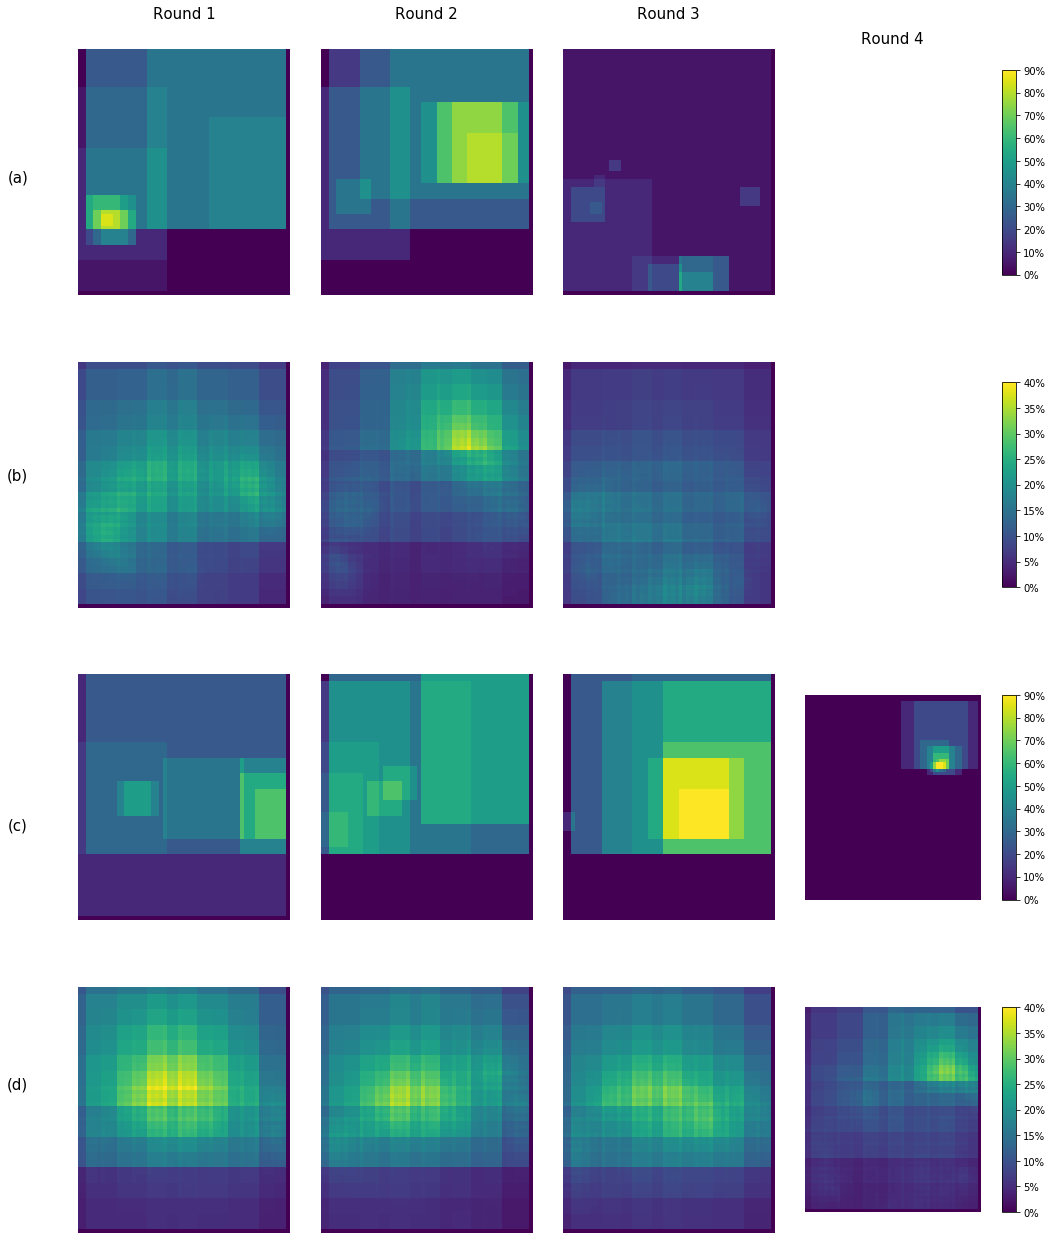

In [ ]:
show_highest_round_correlation_locations([model_loader, model_loader_2], [0, 1])

### Presentation

In [ ]:
def show_histogram_all_rounds_conv_layers_only(model_loader, flight_num, use_pgf = False, file_name = None):
    corrs = []
    conv_layers = np.arange(0, 17, 2)
    
    for round_num in range(3):
        corr = get_round_correlations(model_loader, flight_num, round_num = round_num)
        
        for c in corr:
            if c.layer in conv_layers:
                c.layer = c.layer // 2
                corrs.append(c)
        
    fig = hist3d(corrs, bins = 45, pearson = True, conv_layers_only=True)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show() 

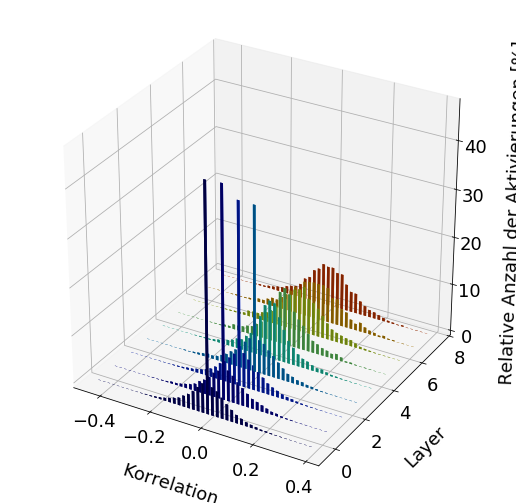

In [ ]:
show_histogram_all_rounds_conv_layers_only(model_loader, flight_num = 0, file_name='ae_histogram_flight_1.png')

In [ ]:
def show_conv_layer_correlations(pearson = True, show_filter_num = 0, use_pgf = False, file_name = None):
    start = get_start_round(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, flight_num = 0, round_num = 0)
    end = get_end_round(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, flight_num = 0, round_num = 0)

    activations = DataLoader.load_activations(model_loader, start, end)
    spike_rate = get_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num = 0)[start : end]
    
    corrs = Correlation.correlate(activations, spike_rate)
    
    current_layer = 0
    current_activation = 0
    current_row_number = 0
    current_row = []
    current_image = []
    correlation_images = []
    
    layer_arrays = []

    max_corr = 0
    min_corr = 0
    if pearson:
        max_corr = max(corrs, key=attrgetter('pearson')).pearson
        min_corr = min(corrs, key=attrgetter('pearson')).pearson
    else:
        # remove nans since max of spearman correlation list with nan returns nan
        corrs_without_nan = [c.spearman for c in corrs if not math.isnan(c.spearman)]
        max_corr = max(corrs_without_nan)
        min_corr = min(corrs_without_nan)
    
    for corr in corrs:
        if current_row_number != corr.row:        
            current_image.append(np.array(current_row))

            current_row_number = corr.row
            current_row.clear()

        if current_activation != corr.filter_num:        
            if current_activation == show_filter_num:
                img = np.array(current_image)
                correlation_images.append(img)

            current_activation = corr.filter_num
            current_image.clear()

        if current_layer != corr.layer:
            current_layer = corr.layer

        corr_value = corr.pearson if pearson else corr.spearman
        
        current_row.append(corr_value)
        
    image_count = len(correlation_images)
    fig = plt.figure(figsize = (PAGE_WIDTH, 2))
    
    for image_num in range(0, image_count, 2):
        ax = fig.add_subplot(1, image_count, image_num + 1)
        im = ax.imshow(correlation_images[image_num], vmin = min_corr, vmax = max_corr)
        ax.axis('off')
        
    fig.subplots_adjust(bottom=0.25, top=1, left = 0.05, right = 0.95, wspace = -0.4)
    
    cbar_ax = fig.add_axes([0.26, 0.15, 0.5, 0.08])
    fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    
    cbar_ax.tick_params(labelsize = FONT_SIZE_LABEL)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show() 

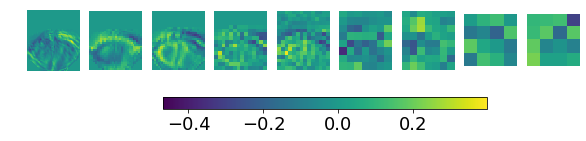

In [ ]:
show_conv_layer_correlations(file_name = 'ae_example_correlations.png')

In [ ]:
def show_highest_round_correlation_locations_presentation(model_loaders, flight_nums, dummy=False, use_pgf=False, file_name=None):
    
    def add_colorbar(ax, im, count):        
        ax_pos = ax.get_position() 
        left = ax_pos.x0 + ax_pos.width + 0.03
        bottom = ax_pos.y0
        width = 0.03
        height = ax_pos.height
        
        cax = fig.add_axes([left, bottom, width, height])
        cax.tick_params(labelsize = FONT_SIZE_LABEL)
        
        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
        
        if count == 20:
            cbar.set_ticks([0, 30, 60, 90])
            cbar.set_ticklabels(['0 %', '30 %', '60 %', '90 %'])
        else:
            cbar.set_ticks([0, 10, 20, 30, 40])
            cbar.set_ticklabels(['0 %', '10 %', '20 %', '30 %', '40 %'])
            
        
    
    fig = plt.figure(figsize=(PAGE_WIDTH, 6.5))
    
    round_nums = max([len(start_rounds[FLIGHT_DAY_SEPTEMBER][flight_num]) for flight_num in flight_nums])
    
    rows = len(flight_nums) * 2
    cols = round_nums
    
    colorbar_args = []
    
    for current_flight_index in range(len(flight_nums)):
        model_loader = model_loaders[flight_nums[current_flight_index]]
        flight_num = flight_nums[flight_nums[current_flight_index]]
        rounds = len(start_rounds[FLIGHT_DAY_SEPTEMBER][flight_num])
        
        flight_plot_start = current_flight_index * cols * 2
        
        last_images = [None, None]
        
        for round_num in range(rounds):
            round_corrs = get_round_correlations(model_loader, flight_num, round_num = round_num, dummy = dummy)

            round_corrs = sorted(round_corrs, key=attrgetter('pearson'), reverse=True)

            if not dummy:
                print("Highest pearson correlation round {}: {}".format(round_num + 1, round_corrs[0].pearson))

            for count in [20, 5000]:                
                if count == 20:
                    ax = fig.add_subplot(rows, cols, flight_plot_start + round_num + 1)
                else:
                    ax = fig.add_subplot(rows, cols, flight_plot_start + round_num + 1 + cols)

                corr_image = get_corr_locations(round_corrs, count)
                
                if not dummy:
                    print("    Most used pixel in {} highest correlations has {} hits".format(count, np.amax(corr_image)))

                vmax = 90 if count == 20 else 40
                im = ax.imshow(corr_image, vmin = 0, vmax = vmax)
                ax.axis('off') 

                if round_num == 2:
                    colorbar_args.append((ax, im, count))
                    
                last_images[0 if count == 20 else 1] = im
        
        if rounds < cols:
            for round_num in range(rounds + 1, cols + 1):
                for count in [20, 5000]:
                    empty = np.full((64, 55), np.nan)

                    current_cmap = matplotlib.cm.get_cmap()
                    current_cmap.set_bad(alpha=0)  

                    if count == 20:
                        ax = fig.add_subplot(rows, cols, flight_plot_start + round_num)
                        
                        if current_flight_index == 0:
                            ax.set_title("Round {}".format(round_num), fontsize = FONT_SIZE_LABEL, y = 1.1)
                    else:
                        ax = fig.add_subplot(rows, cols, flight_plot_start + round_num + cols)
                        
                    vmax = 90 if count == 20 else 40
                    ax.imshow(empty, vmin = 0, vmax = vmax)
                    ax.axis('off')

                    if round_num == cols:
                        colorbar_args.append((ax, last_images[0 if count == 20 else 1], count))
       
    
    fig.subplots_adjust(bottom=0.02, top=0.94, left = 0.06, right = 0.87, hspace=0.1, wspace=0.1)
    
    for ax, im, count in colorbar_args:
        add_colorbar(ax, im, count)
     
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show() 

Highest pearson correlation round 1: 0.3960516641577258
    Most used pixel in 20 highest correlations has 70.0 hits
    Most used pixel in 5000 highest correlations has 28.38 hits
Highest pearson correlation round 2: 0.32432078449242574
    Most used pixel in 20 highest correlations has 85.0 hits
    Most used pixel in 5000 highest correlations has 37.68 hits
Highest pearson correlation round 3: 0.23032638377612216
    Most used pixel in 20 highest correlations has 65.0 hits
    Most used pixel in 5000 highest correlations has 20.28 hits


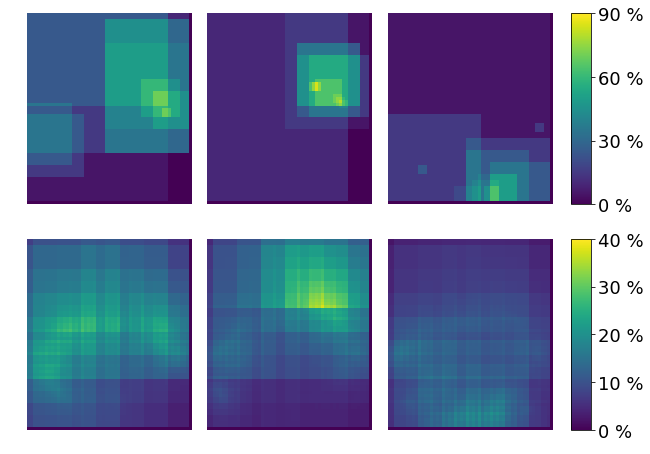

In [ ]:
show_highest_round_correlation_locations_presentation([model_loader], [0], dummy = False, use_pgf=False, file_name='ae_hits_rounds.png')

## Local analysis

In [ ]:
def show_highest_sliced_correlation_sum_locations(model_loaders, flight_nums, window_size, dummy=False,
                                                  use_pgf=False, file_name=None):
    
    def add_colorbar(ax, im):
        ax_pos = ax.get_position() 
        left = ax_pos.x0 + ax_pos.width + 0.02
        bottom = ax_pos.y0
        width = 0.03
        height = ax_pos.height
        
        cax = fig.add_axes([left, bottom, width, height])
        cax.tick_params(labelsize = FONT_SIZE_LABEL)

        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
        cbar.set_ticks([0, 25, 50, 75])
        cbar.set_ticklabels(['0 \%', '25 \%', '50 \%', '75 \%'])
    
    fig = plt.figure(figsize=(PAGE_WIDTH, 3))
    
    round_nums = max([len(start_rounds[FLIGHT_DAY_SEPTEMBER][flight_num]) for flight_num in flight_nums])
    
    rows = len(flight_nums)
    cols = round_nums
    
    colorbar_args = []
    
    for current_flight_index in range(len(flight_nums)):
        model_loader = model_loaders[flight_nums[current_flight_index]]
        flight_num = flight_nums[flight_nums[current_flight_index]]
        rounds = len(start_rounds[FLIGHT_DAY_SEPTEMBER][flight_num])
    
        for round_num in range(rounds):
            round_corrs = get_round_correlations(model_loader, flight_num, round_num, window_size, dummy=dummy)

            if not dummy:            
                for corr in round_corrs:
                    corr.pearson = sum(c for c in corr.pearson if not math.isnan(c))

            round_corrs = sorted(round_corrs, key=attrgetter('pearson'), reverse=True)
            corr_image = get_corr_locations(round_corrs, 100)

            if not dummy:
                print(np.amax(corr_image))

            ax = fig.add_subplot(rows, cols, current_flight_index * cols + round_num + 1)
            
            if current_flight_index == 0:
                ax.set_title("Round {}".format(round_num + 1), fontsize = FONT_SIZE_LABEL, y = 1.1)

            im = ax.imshow(corr_image, vmin = 0, vmax = 75)
            ax.axis('off') 

            if round_num == cols - 1:
                colorbar_args.append((ax, im))

        if rounds < cols:
            for round_num in range(rounds + 1, cols + 1):
                empty = np.full((64, 55), np.nan)

                current_cmap = matplotlib.cm.get_cmap()
                current_cmap.set_bad(alpha=0)  

                ax = fig.add_subplot(rows, cols, current_flight_index * cols + round_num)
                        
                if current_flight_index == 0:
                    ax.set_title("Round {}".format(round_num), fontsize = FONT_SIZE_LABEL, y = 1.1)
                        
                ax.imshow(empty, vmin = 0, vmax = 70)
                ax.axis('off')

                if round_num == cols:
                    colorbar_args.append((ax, im))
    
    fig.text(0.02, 0.67, '(a)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.02, 0.2, '(b)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    fig.subplots_adjust(bottom=0.025, top=0.88, left = 0.06, right = 0.87, hspace=0.2, wspace=0.1)
    
    for ax, im in colorbar_args:
        add_colorbar(ax, im)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show() 

In [ ]:
show_highest_sliced_correlation_sum_locations([model_loader, model_loader_2], flight_nums=[0,1], window_size=20,
                                              use_pgf=True, file_name="ae_hits_windowed.pgf")

entry_count:  137728 , windows:  74 , window_size:  20
57.99999999999999
entry_count:  137728 , windows:  73 , window_size:  20
60.0
entry_count:  137728 , windows:  73 , window_size:  20
39.0
entry_count:  137728 , windows:  73 , window_size:  20
30.0
entry_count:  137728 , windows:  74 , window_size:  20
40.0
entry_count:  137728 , windows:  74 , window_size:  20
17.0
entry_count:  137728 , windows:  72 , window_size:  20
20.0


## Detection of best activations

In [ ]:
def get_highest_sliced_summed_corr(model_loader, flight_num, round_num, window_size):
    round_corrs = get_round_correlations(model_loader, flight_num, round_num, window_size)
        
    corr_sums = []
    for corr in round_corrs:
        corr_sums.append((sum(c for c in corr.pearson if not math.isnan(c)), corr))
        
    corr_sums = sorted(corr_sums, key=lambda x : x[0], reverse=True)
    round_corrs = [c[1] for c in corr_sums]
    
    return round_corrs[0]

def plot_cross_autocorrelation(auto_corrs, window_size, delta, smoothness, use_pgf=False, file_name=None):
    scale = get_scale_to_seconds(RES_MEDIUM)
    delta = delta / scale
    auto_corrs_pearson = [c.pearson for c in auto_corrs]
    
    starts = [get_start_round(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, flight_num = 0,
                              round_num = round_num) / scale for round_num in range(3)]
    
    fig = plt.figure(figsize=(PAGE_WIDTH, 3))
    ax = fig.add_subplot(1,1,1)
    
    x = [get_x_values_in_seconds(auto_corrs_pearson, RES_MEDIUM)]
    
    plot(ax, [auto_corrs_pearson], labels = ["smoothed SWC"], x_values = x, smoothness = smoothness,
         show_unsmoothed_points = True, linewidth=1)
            
    ax.axvspan(0, starts[0] - delta, color='blue', alpha=0.2)
    ax.axvspan(starts[0] - delta, starts[0] + delta, color='red', alpha=0.2)
    
    ax.axvspan(starts[0] + delta, starts[1] - delta, color='blue', alpha=0.2)
    ax.axvspan(starts[1] - delta, starts[1] + delta, color='green', alpha=0.2)
    
    ax.axvspan(starts[1] + delta, starts[2] - delta, color='blue', alpha=0.2)
    ax.axvspan(starts[2] - delta, starts[2] + delta, color='green', alpha=0.2)
    ax.axvspan(starts[2] + delta, len(auto_corrs) / scale, color='blue', alpha=0.2)
    
    fig.text(0.58, 0.02, 'time [s]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.02, 0.55, 'pearson correlation', ha='center', va='center', rotation='vertical',
             fontsize = FONT_SIZE_LABEL)
    
    fig.subplots_adjust(bottom=0.15, top=0.95, left = 0.13, right = 0.98)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show() 
    
def show_highest_cum_cross_cor(model_loader, flight_num, window_size, use_pgf=False, file_name=None):
    max_corr_round_1 = get_highest_sliced_summed_corr(model_loader, flight_num, round_num = 0,
                                                      window_size = window_size)
    
    spike_rate = get_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num)
    
    activations = DataLoader.load_activations(model_loader)
    cross_corrs = Correlation.cross_correlate(activations, spike_rate, max_corr_round_1, window_size)

    start = get_start_round(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, flight_num, round_num = 0)
    end = get_end_round(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, flight_num, round_num = 0)

    window_size = end - start

    plot_cross_autocorrelation(cross_corrs, window_size, delta = 100, smoothness = 30, use_pgf=use_pgf,
                               file_name=file_name)

### Thesis

In [ ]:
show_highest_cum_cross_cor(model_loader, flight_num = 0, window_size = 20, use_pgf=True,
                           file_name='ae_crosscorrelation.pgf')

entry_count:  137728 , windows:  74 , window_size:  20


In [ ]:
patterns_flight_1 = Utils.get_path(["flights", "flight_2018_09_03#1"], "patterns.dill")
patterns_flight_2 = Utils.get_path(["flights", "flight_2018_09_03#2"], "patterns.dill")
patterns = [Utils.load_object(patterns_flight_1), Utils.load_object(patterns_flight_2)]

In [ ]:
def show_highest_distribution_difference_corrs(patterns, use_pgf=False, file_name=None):            
    
    def add_colorbar(ax, fig, im, count_num):
        ax_pos = ax.get_position() 
        left = ax_pos.x0 + ax_pos.width + 0.03
        bottom = ax_pos.y0
        width = 0.03
        height = ax_pos.height

        cax = fig.add_axes([left, bottom, width, height])
        cax.tick_params(labelsize = FONT_SIZE_LABEL)

        cbar = plt.colorbar(im, cax=cax, orientation='vertical')

        if count_num == 0:
            cbar.set_ticks([0, 25, 50, 75, 100])
            cbar.set_ticklabels(['0 \%', '25 \%', '50 \%', '75 \%', '100 \%'])
        else:
            cbar.set_ticks([0, 15, 30, 45])
            cbar.set_ticklabels(['0 \%', '15 \%', '30 \%', '45 \%'])
    
    
    fig = plt.figure(figsize=(PAGE_WIDTH, 3))
    fig.subplots_adjust(bottom=0.04, top=0.9, left = 0.09, right = 0.75, hspace=0, wspace=0.03)
    
    
    ks_p_sorted = [sorted(patterns[i], key=attrgetter('ks_p'), reverse=False) for i in range(len(patterns))]
    mw_p_sorted = [sorted(patterns[i], key=attrgetter('mw_p'), reverse=False) for i in range(len(patterns))]
    
    colorbar_params = []
    
    value_num = 0
    count_num = 0
    for values in [ks_p_sorted[0], ks_p_sorted[1], mw_p_sorted[0], mw_p_sorted[1]]:
        for count in [20, 5000]:
            ax = fig.add_subplot(2, 4, 1 + value_num + (4 * count_num))
            ax.axis('off')
            
            corr_image = get_corr_locations(values, count)
            
            vmax = 100 if count_num == 0 else 45
            im = ax.imshow(corr_image, vmin = 0, vmax = vmax)
            
            if count_num == 0:
                #title = "KS test" if value_num == 0 else "Mann–Whitney \nU test"
                title = "Flight 1" if value_num == 0 or value_num == 2 else "Flight 2"
                ax.set_title(title, fontsize = FONT_SIZE_LABEL, y = 1.1)
            
            if value_num == 3:
                colorbar_params.append((ax, fig, im, count_num))

            
            # padding to plots of Mann–Whitney U test
            if value_num > 1:
                bbox=ax.get_position()
                offset = 0.05
                plt.gca().set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
            
            count_num += 1
        
        count_num = 0
        value_num += 1
    
    for ax, fig, im, count_num in colorbar_params:
        add_colorbar(ax, fig, im, count_num)
    
    fig.text(0.04, 0.69, '(a)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.04, 0.24, '(b)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    fig.text(0.25, 0.02, 'KS test', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.64, 0.02, 'Mann–Whitney U test', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show() 

In [ ]:
show_highest_distribution_difference_corrs(patterns, use_pgf=True, file_name="ae_distribution_flight.pgf")

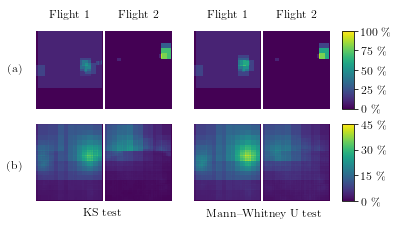

In [ ]:
show_highest_distribution_difference_corrs(patterns)

### Presentation

In [ ]:
start = get_start_round(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, 0, 0)
end = get_end_round(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, 0, 0)

max_corr_round_1 = get_highest_sliced_summed_corr(model_loader, flight_num=0, round_num = 0, window_size = 20)
activations = DataLoader.load_activations(model_loader, start, end)
activation_series = max_corr_round_1.get_activation_series(activations)

spike_rate = get_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=0)

In [ ]:
def plot_series(series, y_label, is_correlation=False, display_x_label=True, fig_width=PAGE_WIDTH, color=None,
                file_name=None):
    fig = plt.figure(figsize=(fig_width, 1.7))
    ax = fig.add_subplot(111)

    if is_correlation:
        x = np.arange(0, len(series) * 2, step=2)
        ax.plot(x, series, color=color)
    else:
        x = get_x_values_in_seconds(series, RES_MEDIUM)    
        ax.plot(x, series, 'k-')
    
    if not is_correlation:
        scale = get_scale_to_seconds(RES_MEDIUM)
        for i in range(0, len(series) // scale, 20 // scale):
            ax.axvspan(i, i, color='blue', alpha=0.2)
        
    fig.set_facecolor("w")
    
    left = 0.09 if fig_width == PAGE_WIDTH else 0.14
    fig.subplots_adjust(left,bottom=0.27, top=0.95, right=0.95)
    fig.text(0.02, 0.6, y_label, ha='center', va='center', rotation='vertical', fontsize = FONT_SIZE_LABEL)
    
    if display_x_label:
        fig.text(0.5, 0.06, 'Zeit [s]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    backend_inline(fig, file_name)
    plt.show()

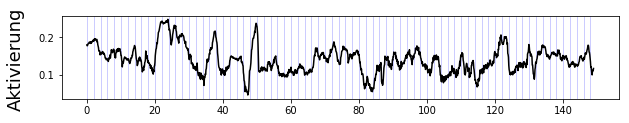

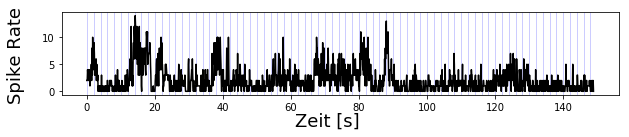

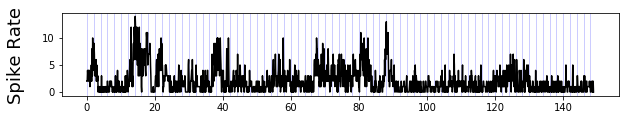

In [ ]:
plot_series(activation_series, 'Aktivierung', display_x_label=False, file_name='ae_first_round_activation.png')
plot_series(spike_rate[start:end], 'Spike Rate', file_name='ae_first_round_spike_rate.png')
plot_series(spike_rate[start:end], 'Spike Rate', display_x_label=False,
            file_name='ae_first_round_spike_rate_2.png')

In [ ]:
def plot_correlation(activation_series, spike_rate_series, window_size, fig_width=PAGE_WIDTH, color=None,
                     file_name=None):
    corrs = []

    for i in range(0, len(activation_series), window_size):
        p = Correlation._pearson(activation_series[i : i + window_size], spike_rate_series[i : i + window_size])
        corrs.append(p)
        
    plot_series(corrs, 'Korrelation', is_correlation=True, display_x_label=True, fig_width=fig_width, color=color,
                file_name=file_name)

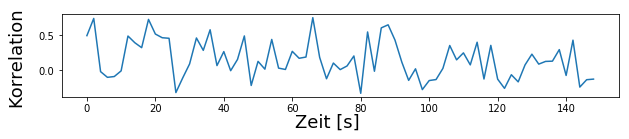

In [ ]:
plot_correlation(activation_series, spike_rate[start:end], window_size=20,
                 file_name='ae_first_round_correlation.png')

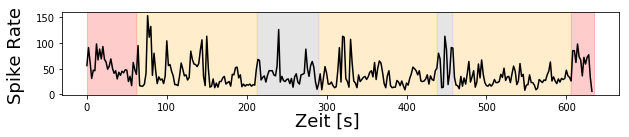

In [ ]:
plot_flight_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=0, use_pgf = False,
                       file_name = "ae_spike_rate.png", bin_size = 20, highlight = 3, small = True)

In [ ]:
def plot_flight_spike_rate_and_activation(activation, flight_day, spike_rate_resolution, flight_num,
                                          use_pgf = False, file_name = None, bin_size = -1, highlight=-1):
    fig = plt.figure(figsize=(PAGE_WIDTH, 1.7))
    ax = fig.add_subplot(111)
    
    spike_rate = get_spike_rate(flight_day, spike_rate_resolution, flight_num)
    
    if bin_size > 1:
        spike_rate = get_bin_data(spike_rate, bin_size)
    
    x = get_x_values_in_seconds(spike_rate, spike_rate_resolution, bin_size)    
    ax.plot(x, spike_rate, color='blue', linewidth=0.5)
    
    ax2 = ax.twinx()
    x = get_x_values_in_seconds(activation, spike_rate_resolution, bin_size)
    ax2.plot(x, activation, color='red', linewidth=0.5)
    
    #highlight sections of flight
    scale = get_scale_to_seconds(spike_rate_resolution)
    round_count = len(start_rounds[flight_day][flight_num])
    
    start_first_round = get_start_round(spike_rate_resolution, flight_day, flight_num, round_num=0) // scale
    end_last_round = get_end_round(spike_rate_resolution, flight_day, flight_num,
                                   round_num=round_count - 1) // scale
    
    
    if highlight > 0:
        ax.axvspan(0, start_first_round - 1, color='red', alpha=0.2)
        
        if bin_size > 1:
            ax.axvspan(end_last_round + 1, len(spike_rate) * bin_size // scale, color='red', alpha=0.2)
        else:
            ax.axvspan(end_last_round + 1, len(spike_rate) // scale, color='red', alpha=0.2)
    
    for round_num in range(round_count):
        start = get_start_round(spike_rate_resolution, flight_day, flight_num, round_num) // scale
        end = get_end_round(spike_rate_resolution, flight_day, flight_num, round_num) // scale
        
        if highlight > 1:
            ax.axvspan(start, end, color='orange', alpha=0.2)
        
        if highlight > 2 and round_num > 0:
            end_prev_round = get_end_round(spike_rate_resolution, flight_day, flight_num,
                                           round_num=round_num - 1) // scale
            
            ax.axvspan(end_prev_round + 1, start - 1, color='gray', alpha=0.2)
    
    if highlight > 3:
        start = 0 if highlight == 4 else 10 // scale
        end = 1490 // scale if highlight == 4 else 1500 // scale
        
        for i in range(start, end, 20 // scale):
            ax.axvspan(i, i, color='blue', alpha=0.2)
    
    fig.set_facecolor("w")    
    fig.tight_layout()
    
    fig.subplots_adjust(left=0.09,bottom=0.27, top=0.95, right=0.9)
    fig.text(0.02, 0.6, 'Spike Rate', ha='center', va='center', rotation='vertical', fontsize = FONT_SIZE_LABEL,
             color='blue')
    fig.text(0.96, 0.6, 'Aktivierung', ha='center', va='center', rotation='vertical', fontsize = FONT_SIZE_LABEL,
             color='red')
    fig.text(0.5, 0.06, 'Zeit [s]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show()

In [ ]:
activations_flight = DataLoader.load_activations(model_loader)
activation_flight_series = max_corr_round_1.get_activation_series(activations_flight)

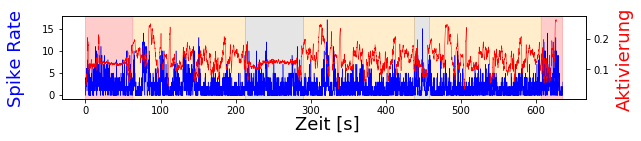

In [ ]:
plot_flight_spike_rate_and_activation(activation_flight_series, FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=0,
                                      highlight=3, file_name='ae_activation_and_spike_rate.png')

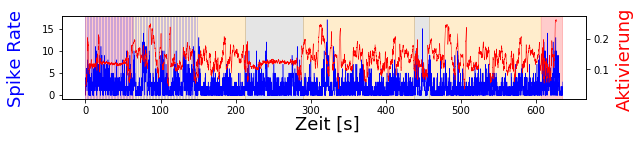

In [ ]:
plot_flight_spike_rate_and_activation(activation_flight_series, FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=0,
                                      highlight=4, file_name='ae_activation_and_spike_rate_2.png')

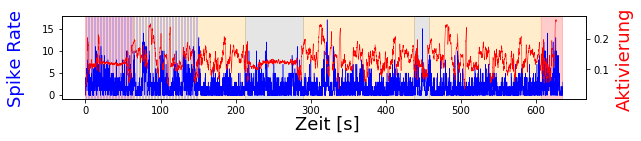

In [ ]:
plot_flight_spike_rate_and_activation(activation_flight_series, FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=0,
                                      highlight=5, file_name='ae_activation_and_spike_rate_3.png')

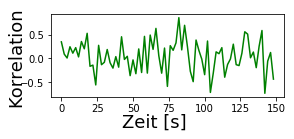

In [ ]:
corr_length = end - start
plot_correlation(activation_flight_series[ : corr_length], spike_rate[ : corr_length], window_size=20,
                 fig_width=PAGE_WIDTH // 2, color='green', file_name='ae_corr_1.png')

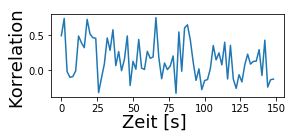

In [ ]:
plot_correlation(activation_flight_series[start:end], spike_rate[start:end], window_size=20,
                 fig_width=PAGE_WIDTH // 2, file_name='ae_first_round_correlation_short.png')

In [ ]:
def plot_cross_autocorrelation_presentation(auto_corrs, window_size, delta, smoothness, only_smoothed=False,
                                            show_legend=False, fig_height=3, highlight=-1, color=None,
                                            use_pgf=False, file_name=None):
    scale = get_scale_to_seconds(RES_MEDIUM)
    delta = delta / scale
    auto_corrs_pearson = [c.pearson for c in auto_corrs]
    
    starts = [get_start_round(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, flight_num = 0,
                              round_num = round_num) / scale for round_num in range(3)]
    
    fig = plt.figure(figsize=(PAGE_WIDTH, fig_height))
    ax = fig.add_subplot(1,1,1)
    
    x = [get_x_values_in_seconds(auto_corrs_pearson, RES_MEDIUM)]
    
    labels = ["smoothed SWC"] if show_legend else None
    plot(ax, [auto_corrs_pearson], labels, x_values = x, smoothness = smoothness,
         show_unsmoothed_points=not only_smoothed, linewidth=1, color=color)
    
    if highlight > 0:
        ax.axvspan(starts[0] - delta, starts[0] + delta, color='red', alpha=0.2)
    
    if highlight > 1:
        ax.axvspan(starts[1] - delta, starts[1] + delta, color='green', alpha=0.2)
        ax.axvspan(starts[2] - delta, starts[2] + delta, color='green', alpha=0.2)
    
    if highlight > 2:
        ax.axvspan(0, starts[0] - delta, color='blue', alpha=0.2)
        ax.axvspan(starts[0] + delta, starts[1] - delta, color='blue', alpha=0.2)
        ax.axvspan(starts[1] + delta, starts[2] - delta, color='blue', alpha=0.2)
        ax.axvspan(starts[2] + delta, len(auto_corrs) / scale, color='blue', alpha=0.2)
    
    if fig_height > 1:
        fig.text(0.58, 0.04, 'Zeit [s]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
        fig.text(0.02, 0.55, 'Korrelation', ha='center', va='center', rotation='vertical',
                 fontsize = FONT_SIZE_LABEL)
    
    bottom = 0.25 if fig_height == 1 else 0.18
    fig.subplots_adjust(bottom=bottom, top=0.95, left = 0.13, right = 0.98)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show() 

In [ ]:
activations = DataLoader.load_activations(model_loader)
cross_corrs = Correlation.cross_correlate(activations, spike_rate, max_corr_round_1, 20)

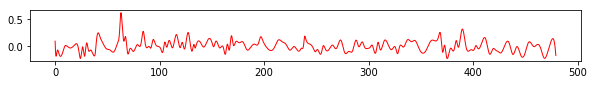

In [ ]:
window_round_size = end - start
plot_cross_autocorrelation_presentation(cross_corrs, window_round_size, delta = 100, smoothness = 30,
                                        only_smoothed=True, show_legend=False, fig_height=1,
                                        color='red', file_name='ae_corr_correlation_small.png')

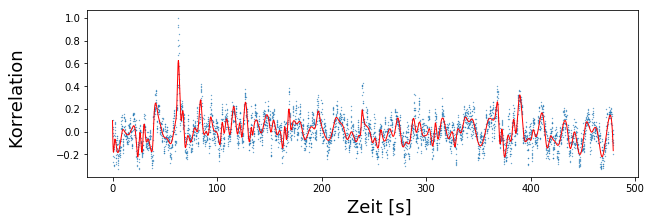

In [ ]:
plot_cross_autocorrelation_presentation(cross_corrs, window_round_size, delta = 100, smoothness = 30,
                                        color='red', only_smoothed=False, show_legend=False, highlight=0,
                                        file_name='ae_corr_correlation_1.png')

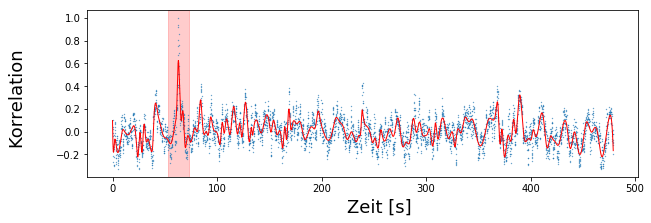

In [ ]:
plot_cross_autocorrelation_presentation(cross_corrs, window_round_size, delta = 100, smoothness = 30,
                                        color='red', only_smoothed=False, show_legend=False, highlight=1,
                                        file_name='ae_corr_correlation_2.png')

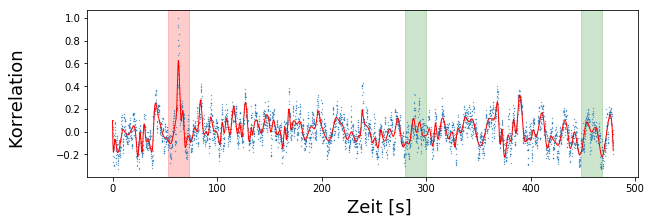

In [ ]:
plot_cross_autocorrelation_presentation(cross_corrs, window_round_size, delta = 100, smoothness = 30,
                                        color='red', only_smoothed=False, show_legend=False, highlight=2,
                                        file_name='ae_corr_correlation_3.png')

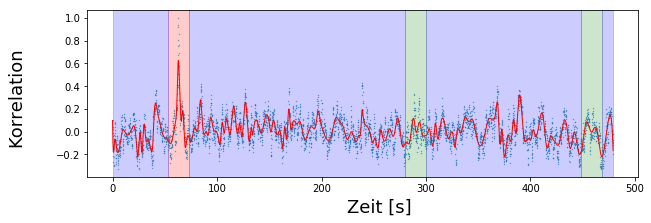

In [ ]:
plot_cross_autocorrelation_presentation(cross_corrs, window_round_size, delta = 100, smoothness = 30,
                                        color='red', only_smoothed=False, show_legend=False, highlight=3,
                                        file_name='ae_corr_correlation_4.png')

In [ ]:
def show_highest_distribution_difference_corrs_presentation(patterns, file_name=None):            
    ks_p_sorted = sorted(patterns, key=attrgetter('ks_p'), reverse=False)
    mw_p_sorted = sorted(patterns, key=attrgetter('mw_p'), reverse=False)
    
    fig = plt.figure(figsize=(0.5 * PAGE_WIDTH, 0.6 * PAGE_WIDTH))
    fig.subplots_adjust(bottom=0.02, top=0.9, left = 0.09, right = 0.7, hspace=0, wspace=0.03)
    
    value_num = 0
    count_num = 0
    for values in [ks_p_sorted, mw_p_sorted]:
        for count in [20, 5000]:
            ax = fig.add_subplot(2, 2, 1 + value_num + (2 * count_num))
            ax.axis('off')
            
            corr_image = get_corr_locations(values, count)
            
            vmax = 100 if count_num == 0 else 45
            im = ax.imshow(corr_image, vmin = 0, vmax = vmax)
            
            if value_num == 1:
                ax_pos = ax.get_position() 
                left = ax_pos.x0 + ax_pos.width + 0.03
                bottom = ax_pos.y0
                width = 0.03
                height = ax_pos.height

                cax = fig.add_axes([left, bottom, width, height])
                cax.tick_params(labelsize = FONT_SIZE_LABEL)

                cbar = plt.colorbar(im, cax=cax, orientation='vertical')

                if count_num == 0:
                    cbar.set_ticks([0, 25, 50, 75, 100])
                    cbar.set_ticklabels(['0 %', '25 %', '50 %', '75 %', '100 %'])
                else:
                    cbar.set_ticks([0, 15, 30, 45])
                    cbar.set_ticklabels(['0 %', '15 %', '30 %', '45 %'])

            count_num += 1
        
        count_num = 0
        value_num += 1
    
    backend_inline(fig, file_name)
    plt.show() 

In [ ]:
patterns_flight_1_path = Utils.get_path(["flights", "flight_2018_09_03#1"], "patterns.dill")
patterns_flight_1 = Utils.load_object(patterns_flight_1_path)

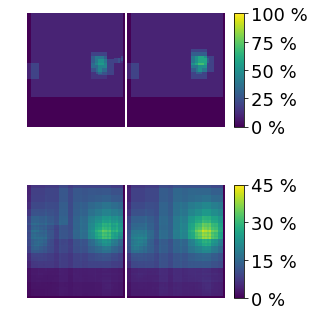

In [ ]:
show_highest_distribution_difference_corrs_presentation(patterns_flight_1, file_name='ae_pattern_result.png')

# Chapter 6: Field Mapping

## Description

In [ ]:
def show_mapping_of_single_frame(flight_day, spike_rate_resolution, flight_num, frame_num, fig_height=3.3,
                                 use_pgf=False, file_name=None):
    coordinates = get_coords(flight_day, spike_rate_resolution, flight_num)
    cam_pos = get_camera_positions(flight_day, spike_rate_resolution, flight_num)

    fig = Visualizer.map_frame(model_loader, frame_num, coordinates, cam_pos, compressed_mask,
                               fig_width = 0.7 * PAGE_WIDTH, fig_height = fig_height)
    
    fig.text(0.03, 0.76, '(a)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.03, 0.22, '(b)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.98, 0.5, '(c)', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show() 
        
def show_mapping(flight_day, spike_rate_resolution, flight_num, round_num,
                 map_function = Visualizer.MAP_FUNCTION.mean, draw_round = True, file_name = None):
    
    coordinates = get_coords(flight_day, spike_rate_resolution, flight_num)
    cam_pos = get_camera_positions(flight_day, spike_rate_resolution, flight_num)
    
    if draw_round:
        start = start_rounds[flight_day][flight_num][round_num]
        end = end_rounds[flight_day][flight_num][round_num]
    else:
        start = start_line[flight_day][flight_num][round_num][0]
        end = end_line[flight_day][flight_num][round_num][0]
    
    fig, _ = Visualizer.map_frames(map_function, model_loader, start, end, coordinates, cam_pos, compressed_mask)
        
    if file_name is not None:
        backend_inline(fig, file_name)
        plt.show()

### Thesis

In [ ]:
show_mapping_of_single_frame(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num = 0, frame_num = 800, use_pgf=True,
                             file_name='map_single_position.pgf')

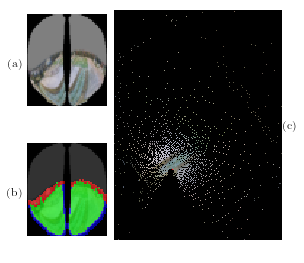

In [ ]:
show_mapping_of_single_frame(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num = 0, frame_num = 800)

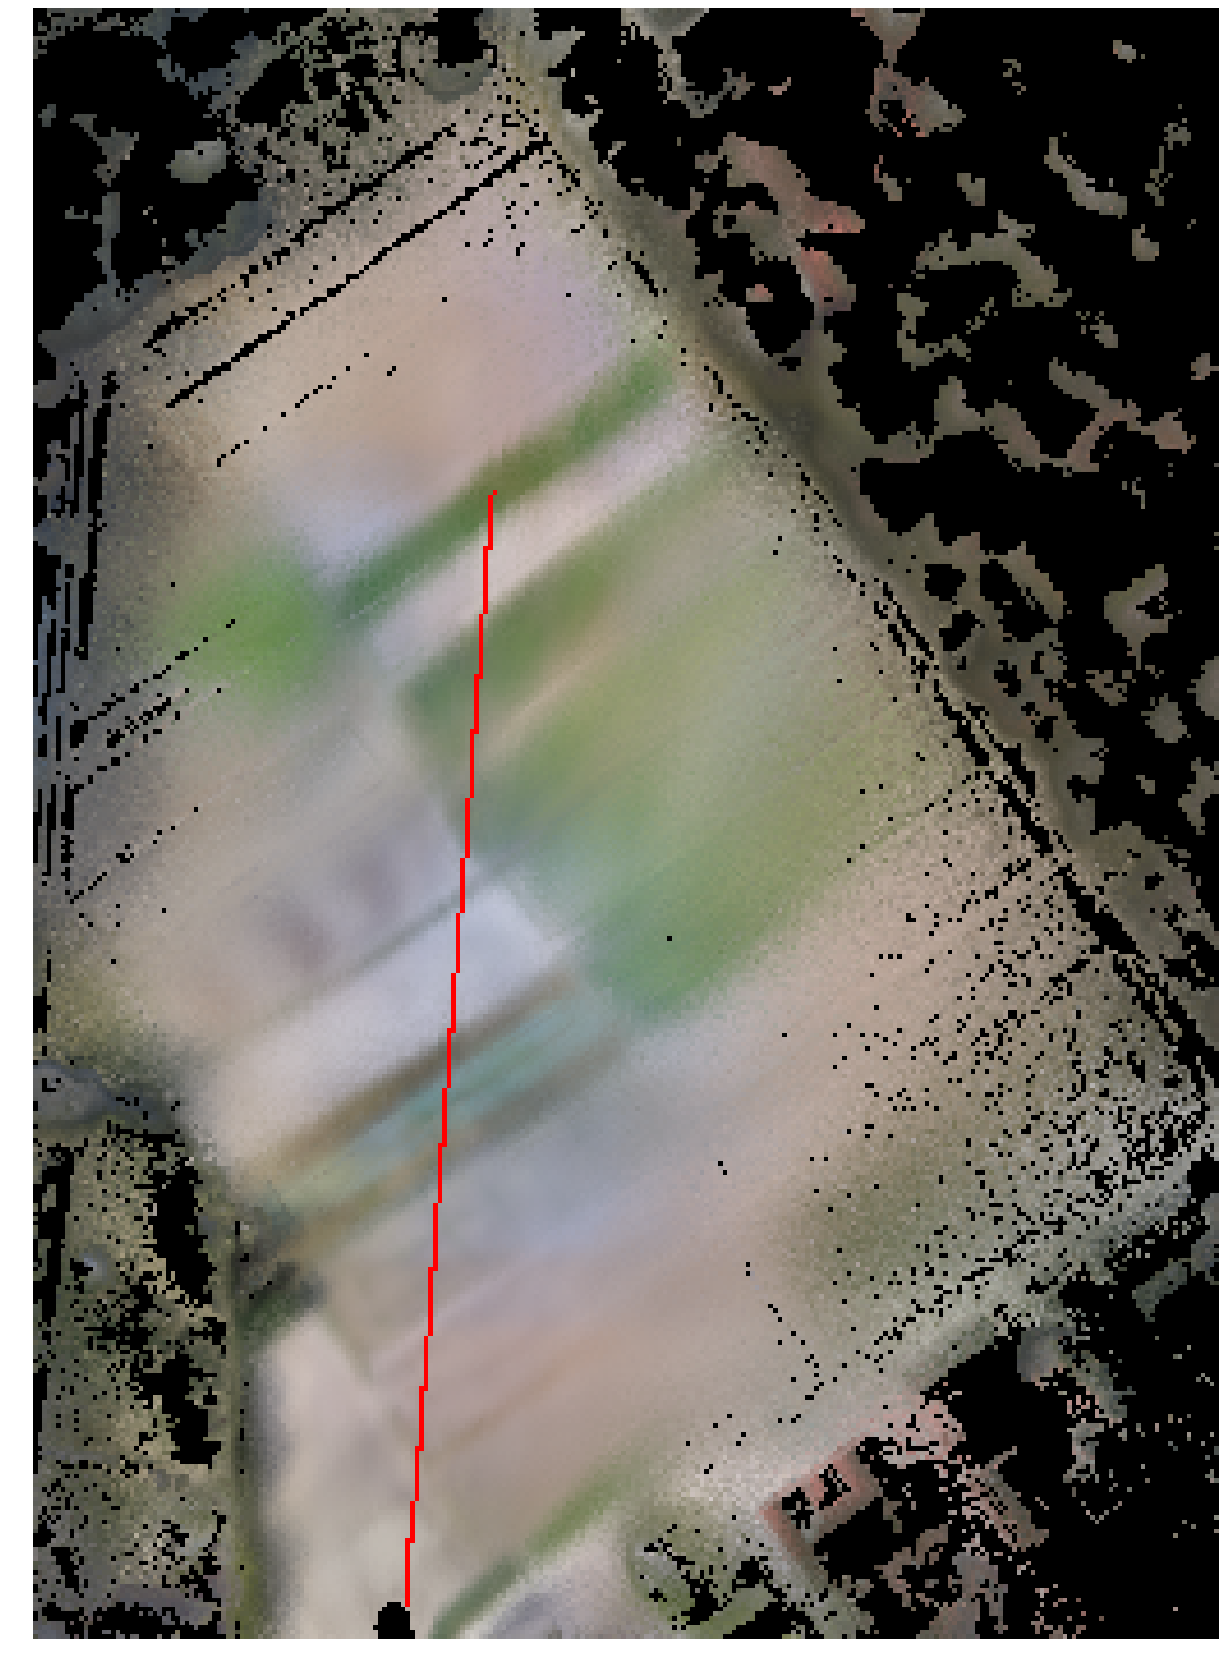

In [ ]:
show_mapping(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num = 0, round_num = 0, draw_round = False)

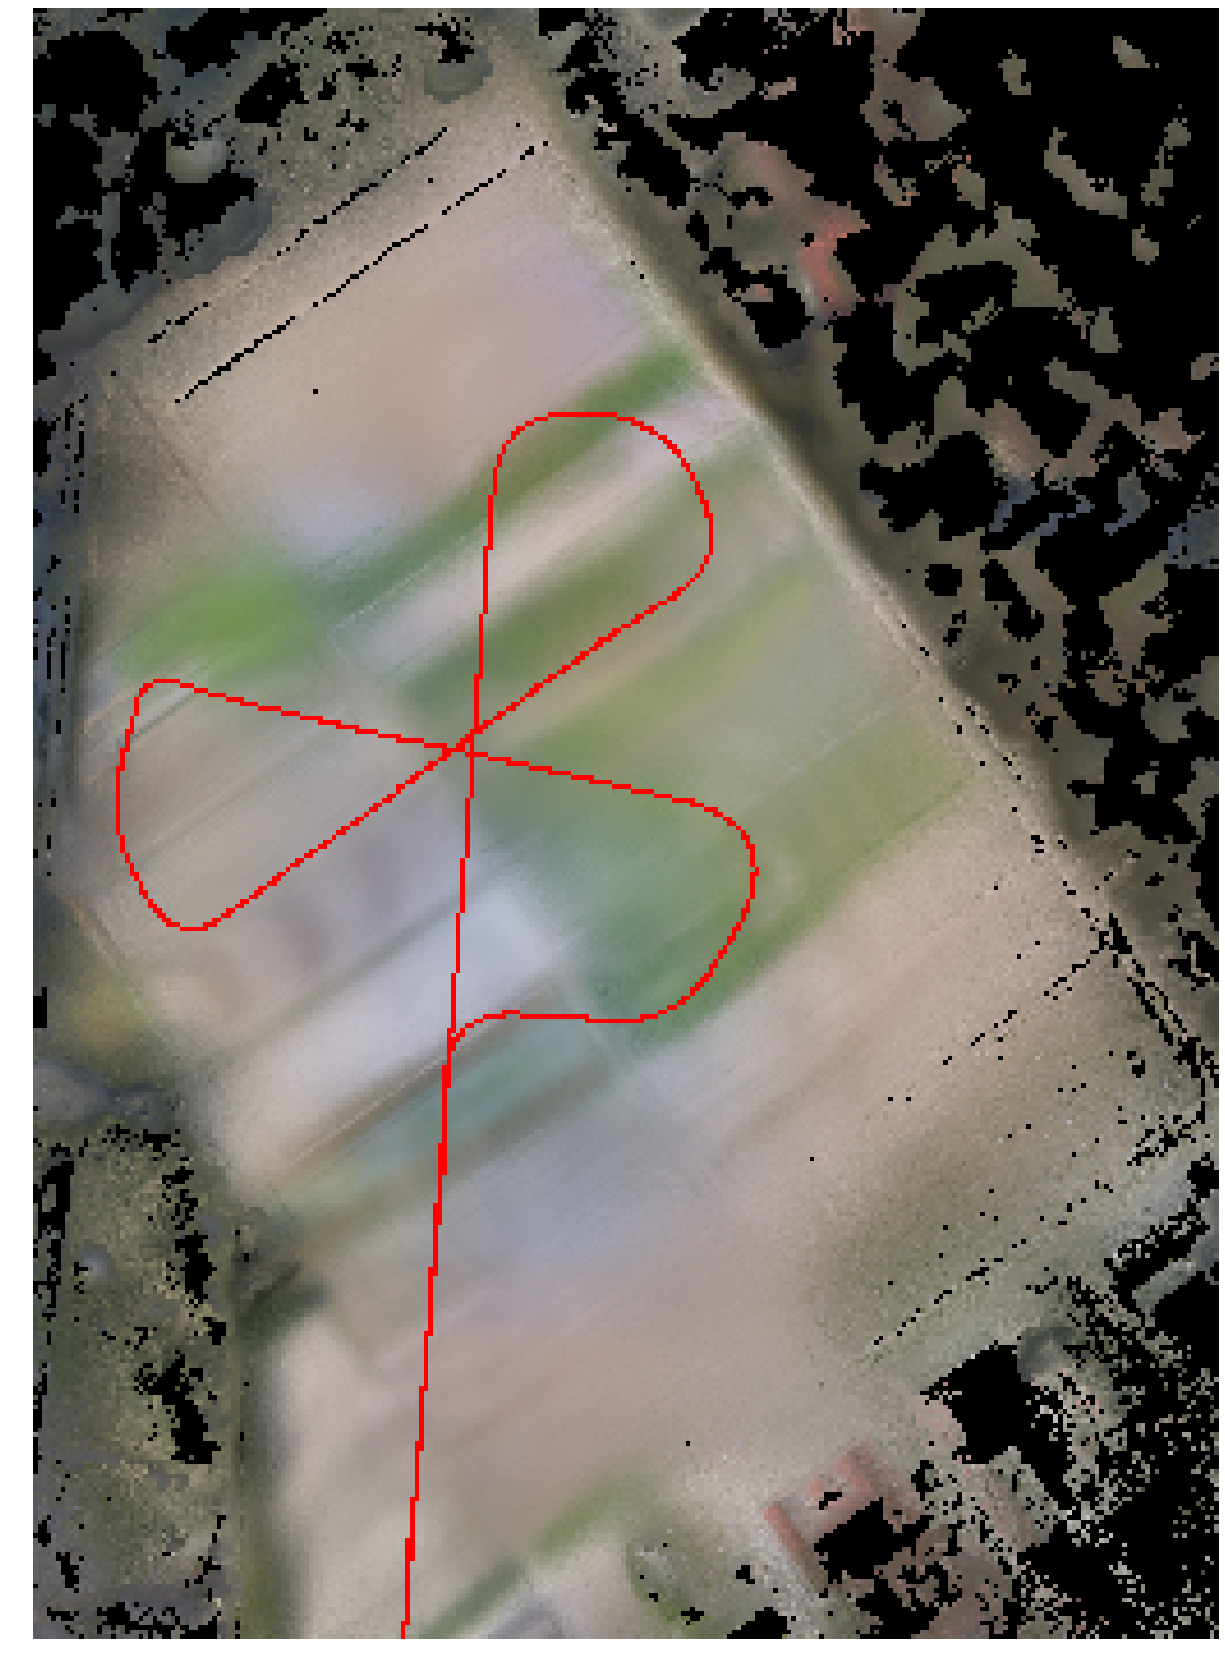

In [ ]:
show_mapping(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num = 0, round_num = 0, draw_round = True)

### Presentation

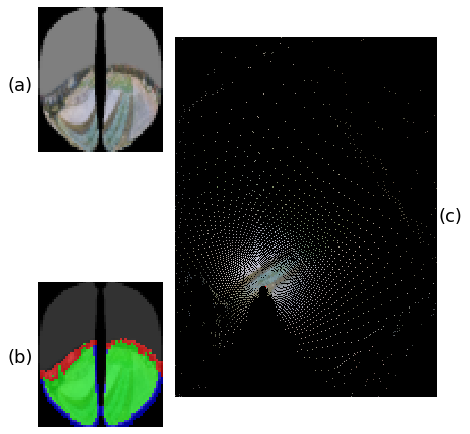

In [ ]:
show_mapping_of_single_frame(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num = 0, frame_num = 800,
                             fig_height=7, file_name='map_single_position.png')

In [ ]:
# outputs frames from start to end of first flight line to show in a video how the map is built step-by-step
def map_frames(model_loader, frame_num_start, frame_num_end, flight_day, spike_rate_resolution, flight_num):
    coordinates = get_coords(flight_day, spike_rate_resolution, flight_num)
    cam_pos = get_camera_positions(flight_day, spike_rate_resolution, flight_num)
    
    fig = plt.figure(figsize = (2, 3.5))
    fig.subplots_adjust(bottom=0, top=1, left = 0, right = 1)
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    for frame_num in range(frame_num_start, frame_num_end):
        frame_coord = coordinates[frame_num]
        camera_position = cam_pos[frame_num]

        delta_x = 187 # distance to leftmost x-coordinate from origin on field
        delta_y = 297 # distance to topmost y-coordinate from origin on field

        for i_batch, (xb, yb) in enumerate(model_loader.data_loader):    
            xbd = xb.data

            if ((i_batch + 1) * model_loader.batch_size) > frame_num:
                break

        img = xbd[frame_num % model_loader.batch_size].data.numpy()
        img = np.transpose(img, (1, 2, 0))
        
        img_map = np.full((355, 258, 4), np.nan)

        for coord in frame_coord:
            x = int(delta_x + np.around(coord[0]))
            y = int(delta_y - np.around(coord[2]))

            # divide by 2 since bee images are scaled down for autoencoder
            bee_x = min(img.shape[1] - 1, int(coord[3] // 2))
            bee_y = min(img.shape[0] - 1, int(coord[4] // 2))

            if y < 0 or x < 0 or y >= img_map.shape[0] or x >= img_map.shape[1]:
                continue

            if compressed_mask is not None and np.array_equal(compressed_mask[bee_y][bee_x],
                                                              np.array([255, 255, 255, 255])):
                continue

            img_map[y, x, : 3] = img[bee_y][bee_x]
            img_map[y, x, 3] = 1

        file_name = '0' if frame_num < 1000 else ''
        file_name += str(frame_num) + ".png"
        
        current_cmap = matplotlib.cm.get_cmap()
        current_cmap.set_bad(alpha=0)  
        
        ax.imshow(img_map)
        backend_inline(fig, file_name, transparent=True)
        
        ax.cla()
        ax.axis('off')

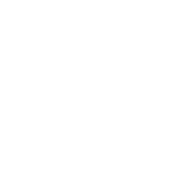

In [ ]:
map_frames(model_loader, frame_num_start=630, frame_num_end=1000, flight_day=FLIGHT_DAY_SEPTEMBER,
           spike_rate_resolution=RES_MEDIUM, flight_num=0)

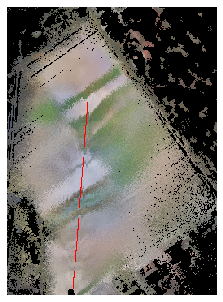

In [ ]:
show_mapping(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num = 0, round_num = 0,
             map_function = Visualizer.MAP_FUNCTION.threshold, draw_round = False, file_name='map_model_line.png')

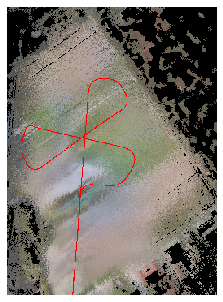

In [ ]:
show_mapping(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num = 0, round_num = 0,
             map_function = Visualizer.MAP_FUNCTION.threshold, draw_round = True, file_name='map_model_round.png')

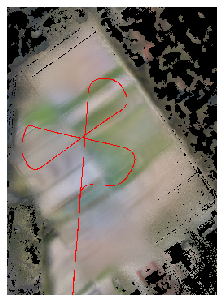

In [ ]:
show_mapping(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num = 0, round_num = 0,
             map_function = Visualizer.MAP_FUNCTION.mean, draw_round = True, file_name='map_model_round_mean.png')

## Map activations of autoencoder

In [ ]:
def save_mapped_activation_map(flight_day, spike_rate_resolution, flight_num, round_num, show_colorbar = True,
                               draw_round = True, use_pgf=False, file_name=None):
    
    coordinates = get_coords(flight_day, spike_rate_resolution, flight_num)
    cam_pos = get_camera_positions(flight_day, spike_rate_resolution, flight_num)
    
    if draw_round:
        start = start_rounds[flight_day][flight_num][round_num]
        end = end_rounds[flight_day][flight_num][round_num]
    else:
        start = start_line[flight_day][flight_num][round_num][0]
        end = end_line[flight_day][flight_num][round_num][0]
    
    fig, fig_colorbar = Visualizer.map_activation_map(Visualizer.MAP_FUNCTION.mean, 0, 0, model_loader, start, end,
                       coordinates, PAGE_WIDTH, show_colorbar, colorbar_label_size = FONT_SIZE_LABEL,
                       camera_positions = cam_pos, mask = compressed_mask)
    
    backend_inline(fig, file_name + '.png')
    plt.show()
    
    if use_pgf:
        backend_pgf(fig, file_name + "_cbar.pgf")
    else:
        backend_inline(fig, file_name + "_cbar.png")
        plt.show()

In [ ]:
save_mapped_activation_map(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num = 0, round_num = 0, draw_round = False, 
                           show_colorbar = True, use_pgf=True, file_name='map_activations_one_line')

In [ ]:
save_mapped_activation_map(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num = 0, round_num = 0, draw_round = True, 
                           show_colorbar = False, use_pgf=False, file_name='map_activations_one_round')

## Map Spike Rate

### Thesis

In [ ]:
def show_map_spike_rate_all_measures(flight_day, spike_rate_resolution, flight_num, use_only_lines, dummy=False,
                                     use_pgf=False, file_name=None):
    spike_rate = get_spike_rate(flight_day, spike_rate_resolution, flight_num)
    coords = get_coords(flight_day, spike_rate_resolution, flight_num)
    camera_positions = get_camera_positions(flight_day, spike_rate_resolution, flight_num)

    rows = len(start_rounds[flight_day][flight_num])
    cols = 5
    
    fig = plt.figure(figsize = (PAGE_WIDTH, 5), facecolor='white')
    fig.subplots_adjust(bottom=0.1, top=0.94, left = 0.08, right = 0.98, hspace=0.1, wspace=0.1)
    
    for round_num in range(rows):
        if use_only_lines:
            start_lines = get_start_lines(spike_rate_resolution, flight_day, flight_num, round_num)
            end_lines = get_end_lines(spike_rate_resolution, flight_day, flight_num, round_num)
        else:
            start_lines = [get_start_round(spike_rate_resolution, flight_day, flight_num, round_num)]
            end_lines = [get_end_round(spike_rate_resolution, flight_day, flight_num, round_num)]

        if dummy:
            map_matrix = np.zeros((355, 258))
        else:
            map_matrix = Visualizer.get_spike_rate_map_matrix(spike_rate, start_lines, end_lines, coords)

        
        ax = fig.add_subplot(rows, cols, 1 + (round_num * cols))        
        title = "Mean" if round_num == 0 else None
        _, _, _ = Visualizer.get_spike_rate_map(map_matrix, Visualizer.MAP_FUNCTION.mean, start_lines, end_lines,
                                                camera_positions, show_colorbar=False, title = title, ax = ax,
                                                dummy=dummy, text_size=FONT_SIZE_LABEL)
        
        ax.annotate("Round {}".format(round_num + 1), (0.5, 0.5), xytext=(-45, 0), ha='right', va='center',
                size=FONT_SIZE_LABEL, rotation=90, xycoords='axes fraction',
                textcoords='offset points')
        
        
        ax = fig.add_subplot(rows, cols, 2 + (round_num * cols)) 
        title = "Min" if round_num == 0 else None
        _, _, _ = Visualizer.get_spike_rate_map(map_matrix, Visualizer.MAP_FUNCTION.min, start_lines, end_lines,
                                                camera_positions, show_colorbar=False, title = title,ax = ax,
                                                dummy=dummy, text_size=FONT_SIZE_LABEL)

        
        ax = fig.add_subplot(rows, cols, 3 + (round_num * cols)) 
        title = "Max" if round_num == 0 else None
        _, _, _ = Visualizer.get_spike_rate_map(map_matrix, Visualizer.MAP_FUNCTION.max, start_lines, end_lines,
                                                camera_positions, show_colorbar=False, title = title, ax = ax,
                                                dummy=dummy, text_size=FONT_SIZE_LABEL)

        
        ax = fig.add_subplot(rows, cols, 4 + (round_num * cols)) 
        title = "Std" if round_num == 0 else None
        _, _, _ = Visualizer.get_spike_rate_map(map_matrix, Visualizer.MAP_FUNCTION.std, start_lines, end_lines,
                                                camera_positions, show_colorbar=False, title = title, ax = ax,
                                                dummy=dummy, text_size=FONT_SIZE_LABEL)

        
        ax = fig.add_subplot(rows, cols, 5 + (round_num * cols)) 
        title = "Var" if round_num == 0 else None
        _, img_map, im = Visualizer.get_spike_rate_map(map_matrix, Visualizer.MAP_FUNCTION.var, start_lines,
                                                       end_lines, camera_positions, show_colorbar=False,
                                                       title = title, ax = ax, dummy=dummy,
                                                       text_size=FONT_SIZE_LABEL)
        
        
    u = np.nanmean(img_map)
    std = np.nanstd(img_map)
        
    vmin = max(0, u - 2 * std)
    vmax = u + 2 * std
    ticks = [vmin, vmin + (vmax - vmin) / 2, vmax]
    
    cbar_ax = fig.add_axes([0.28, 0.055, 0.5, 0.02])
    fig.colorbar(im, cax=cbar_ax, ticks=ticks, orientation='horizontal')
    
    cbar_ax.tick_params(labelsize = FONT_SIZE_LABEL)
    cbar_ax.set_xticklabels(['Low', 'Medium', 'High'])
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show() 

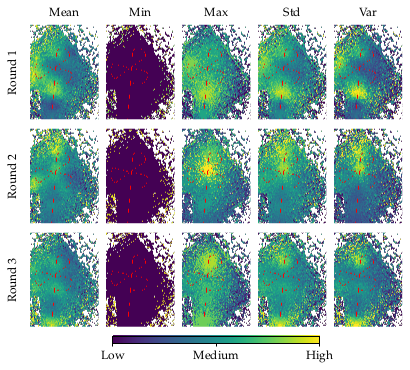

In [ ]:
show_map_spike_rate_all_measures(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=0, use_only_lines=False,
                                 use_pgf=True, file_name="map_spike_rate_different_measures.pgf")

In [ ]:
def show_map_spike_rate_flights_per_day(flight_day, spike_rate_resolution, use_only_lines, dummy=False,
                                        use_pgf=False, file_name=None):
    
    rows = len(start_rounds[flight_day])
    cols = 5 if flight_day == FLIGHT_DAY_AUGUST else 4
    
    row_height = 1.5 if flight_day == FLIGHT_DAY_AUGUST else 2
    
    fig = plt.figure(figsize = (PAGE_WIDTH, rows * row_height), facecolor='white')
    
    bottom = 0.15 if flight_day == FLIGHT_DAY_AUGUST else 0.08
    top = 0.92 if flight_day == FLIGHT_DAY_AUGUST else 0.96
    plt.subplots_adjust(bottom=bottom, top=top, left = 0.08, right = 0.98, hspace=0.1, wspace=0.1)    
    
    row_num = 0
    row_letters = ["(a)", "(b)", "(c)", "(d)"]
     
    for flight_num in range(len(start_rounds[flight_day])):
        spike_rate = get_spike_rate(flight_day, spike_rate_resolution, flight_num)
            
        coords = get_coords(flight_day, spike_rate_resolution, flight_num)
        camera_positions = get_camera_positions(flight_day, spike_rate_resolution, flight_num)
            
        rounds = len(start_rounds[flight_day][flight_num])
            
        for round_num in range(rounds):
            if use_only_lines:
                start_lines = get_start_lines(spike_rate_resolution, flight_day, flight_num, round_num)
                end_lines = get_end_lines(spike_rate_resolution, flight_day, flight_num, round_num)
            else:
                start_lines = [get_start_round(spike_rate_resolution, flight_day, flight_num, round_num)]
                end_lines = [get_end_round(spike_rate_resolution, flight_day, flight_num, round_num)]
                               
            if dummy:
                map_matrix = np.zeros((355, 258))
            else:
                map_matrix = Visualizer.get_spike_rate_map_matrix(spike_rate, start_lines, end_lines, coords)
                
                
            ax = fig.add_subplot(rows, cols, 1 + round_num + (row_num * cols))
            
            title = "Round {}".format(round_num + 1) if flight_num == 0 else None
            _, img_map, im = Visualizer.get_spike_rate_map(map_matrix, Visualizer.MAP_FUNCTION.mean, start_lines,
                                                           end_lines, camera_positions, title = title, ax = ax,
                                                           show_colorbar = False, dummy=dummy,
                                                           text_size=FONT_SIZE_LABEL)
                
            if round_num == 0:
                left = 0.5 if flight_day == FLIGHT_DAY_AUGUST else 0.4
                ax.annotate(row_letters[row_num], (left, 0.5), xytext=(-45, 0), ha='right',
                            va='center', size=FONT_SIZE_LABEL, xycoords='axes fraction',
                            textcoords='offset points')        
            
        if flight_num == 0 and rounds < cols:
            for round_num in range(rounds + 1, cols + 1):
                map_matrix = np.full((355, 258), np.nan)
                    
                current_cmap = matplotlib.cm.get_cmap()
                current_cmap.set_bad(alpha=0)  
                    
                ax = fig.add_subplot(rows, cols, round_num)
                ax.imshow(map_matrix)
                ax.set_title("Round {}".format(round_num), fontsize = FONT_SIZE_LABEL, y = 1.03)
                ax.axis('off')
                    
                print(round_num)
            
        row_num += 1
    
    u = np.nanmean(img_map)
    std = np.nanstd(img_map)
        
    vmin = max(0, u - 2 * std)
    vmax = u + 2 * std
    ticks = [vmin, vmin + (vmax - vmin) / 2, vmax]
    
    height = 0.03 if flight_day == FLIGHT_DAY_AUGUST else 0.015
    width = 0.5
    bottom = 0.085 if flight_day == FLIGHT_DAY_AUGUST else 0.05
    left = 0.275
    cbar_ax = fig.add_axes([left, bottom, width, height])
    fig.colorbar(im, cax=cbar_ax, ticks=ticks, orientation='horizontal')
    
    cbar_ax.tick_params(labelsize = FONT_SIZE_LABEL)
    cbar_ax.set_xticklabels(['Low', 'Medium', 'High'])
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)

In [ ]:
show_map_spike_rate_flights_per_day(FLIGHT_DAY_AUGUST, RES_MEDIUM, use_only_lines=False, use_pgf=True,
                                    file_name='map_spike_rate_august.pgf')

In [ ]:
show_map_spike_rate_flights_per_day(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, use_only_lines=False, use_pgf=True,
                                    file_name='map_spike_rate_september.pgf')

4


4


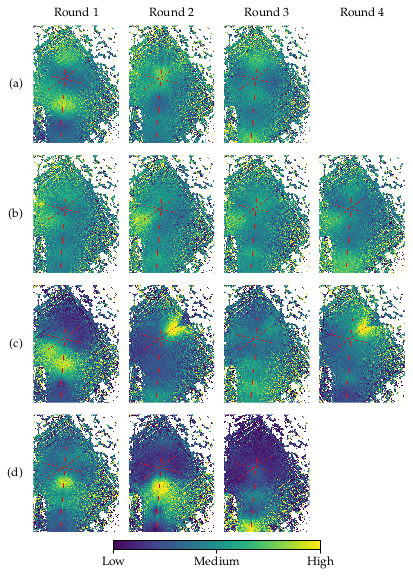

In [ ]:
show_map_spike_rate_flights_per_day(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, use_only_lines=True, use_pgf=True,
                                    file_name='map_spike_rate_september_lines.pgf')

### Presentation

In [ ]:
# outputs frames with mapped spike rate to visualize in a video how overlapping spike rates can be
# merged (i.e. calculation of mean or overriding values over a certain threshold)
def map_spike_rates(frame_num_start, frame_num_end, flight_day, spike_rate_resolution, flight_num):
    coordinates = get_coords(flight_day, spike_rate_resolution, flight_num)
    cam_pos = get_camera_positions(flight_day, spike_rate_resolution, flight_num)
    spike_rate = get_spike_rate(flight_day, spike_rate_resolution, flight_num)
    
    fig = plt.figure(figsize = (2, 3.5))
    fig.subplots_adjust(bottom=0, top=1, left = 0, right = 1)
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    for frame_num in range(frame_num_start, frame_num_end):
        frame_coord = coordinates[frame_num]
        camera_position = cam_pos[frame_num]

        delta_x = 187 # distance to leftmost x-coordinate from origin on field
        delta_y = 297 # distance to topmost y-coordinate from origin on field
        
        img_map = np.full((355, 258), np.nan)

        for coord in frame_coord:
            x = int(delta_x + np.around(coord[0]))
            y = int(delta_y - np.around(coord[2]))

            # divide by 2 since bee images are scaled down for autoencoder
            bee_x = min(compressed_mask.shape[1] - 1, int(coord[3] // 2))
            bee_y = min(compressed_mask.shape[0] - 1, int(coord[4] // 2))

            if y < 0 or x < 0 or y >= img_map.shape[0] or x >= img_map.shape[1]:
                continue

            if compressed_mask is not None and np.array_equal(compressed_mask[bee_y][bee_x],
                                                              np.array([255, 255, 255, 255])):
                continue

            img_map[y, x] = spike_rate[frame_num]

        file_name = 'map_spike_rate_0' if frame_num < 1000 else 'map_spike_rate_'
        file_name += str(frame_num) + ".png"
        
        current_cmap = matplotlib.cm.get_cmap()
        current_cmap.set_bad(alpha=0)  
        
        ax.imshow(img_map, vmin=min(spike_rate[frame_num_start : frame_num_end]),
                  vmax=max(spike_rate[frame_num_start : frame_num_end]))
        backend_inline(fig, file_name, transparent=True)
        
        ax.cla()
        ax.axis('off')

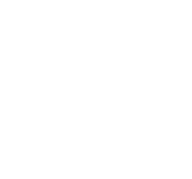

In [ ]:
map_spike_rates(frame_num_start=800, frame_num_end=803, flight_day=FLIGHT_DAY_SEPTEMBER,
           spike_rate_resolution=RES_MEDIUM, flight_num=0)

In [ ]:
def show_round_map_spike_rate(flight_day, spike_rate_resolution, flight_num, round_num, use_only_lines,
                              dummy=False, file_name=None):
        
    fig = plt.figure(figsize = (4,4))
    fig.subplots_adjust(bottom=0.1, top=0.9, left = 0, right = 0.9)
    ax = fig.add_subplot(111)
    ax.axis('off')
     
    spike_rate = get_spike_rate(flight_day, spike_rate_resolution, flight_num)
            
    coords = get_coords(flight_day, spike_rate_resolution, flight_num)
    camera_positions = get_camera_positions(flight_day, spike_rate_resolution, flight_num)
            
    if use_only_lines:
        start_lines = get_start_lines(spike_rate_resolution, flight_day, flight_num, round_num)
        end_lines = get_end_lines(spike_rate_resolution, flight_day, flight_num, round_num)
    else:
        start_lines = [get_start_round(spike_rate_resolution, flight_day, flight_num, round_num)]
        end_lines = [get_end_round(spike_rate_resolution, flight_day, flight_num, round_num)]
                               
    if dummy:
        map_matrix = np.zeros((355, 258))
    else:
        map_matrix = Visualizer.get_spike_rate_map_matrix(spike_rate, start_lines, end_lines, coords)
                
                
            
    _, img_map, im = Visualizer.get_spike_rate_map(map_matrix, Visualizer.MAP_FUNCTION.mean, start_lines,
                                                   end_lines, camera_positions, ax = ax, show_colorbar = True,
                                                   dummy=dummy, text_size=FONT_SIZE_LABEL)
    
    backend_inline(fig, file_name)

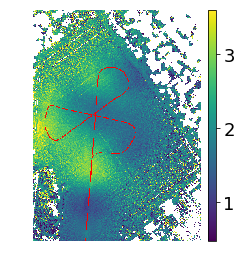

In [ ]:
show_round_map_spike_rate(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=0, round_num=0, use_only_lines=False,
                              dummy=False, file_name='map_september_flight1_round1.png')

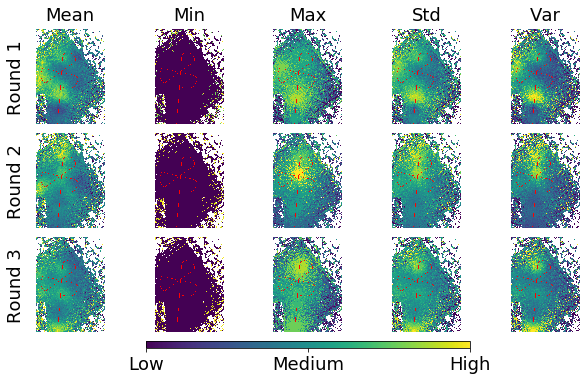

In [ ]:
show_map_spike_rate_all_measures(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=0, use_only_lines=False,
                                 use_pgf=False, file_name="map_spike_rate_different_measures.png")

4


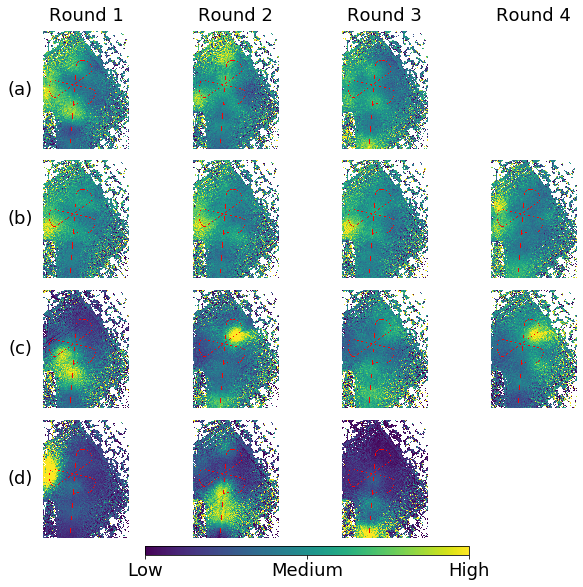

In [ ]:
show_map_spike_rate_flights_per_day(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, use_only_lines=False,
                                    use_pgf=False, file_name='map_spike_rate_september.png')

# Chapter 7: Discussion

In [ ]:
def show_hit_point_count(flight_day, spike_rate_resolution, flight_num, round_num, lines_only, dummy=False,
                         use_pgf=False, file_name=None):
    
    spike_rate = get_spike_rate(flight_day, spike_rate_resolution, flight_num)
    coords = get_coords(flight_day, spike_rate_resolution, flight_num)
    camera_positions = get_camera_positions(flight_day, spike_rate_resolution, flight_num)
    
    fig = plt.figure(figsize = (PAGE_WIDTH * 0.5, 2.5))
    plt.subplots_adjust(bottom=0.05, top=0.95, left = 0.1, right = 0.76)  
    
    if lines_only:
        start_lines = get_start_lines(spike_rate_resolution, flight_day, flight_num, round_num)
        end_lines = get_end_lines(spike_rate_resolution, flight_day, flight_num, round_num)
    else:
        start_lines = [get_start_round(spike_rate_resolution, flight_day, flight_num, round_num)]
        end_lines = [get_end_round(spike_rate_resolution, flight_day, flight_num, round_num)]
    
    if dummy:
        map_matrix = np.zeros((355, 258))
    else:
        map_matrix = Visualizer.get_spike_rate_map_matrix(spike_rate, start_lines, end_lines, coords)
        
    ax = fig.add_subplot(111)
    _, _, _ = Visualizer.get_spike_rate_map(map_matrix, Visualizer.MAP_FUNCTION.count, start_lines, end_lines,
                                            camera_positions, ax = ax, dummy=dummy, text_size=FONT_SIZE_LABEL)
    
    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)

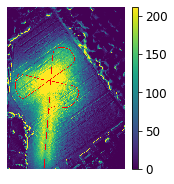

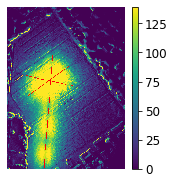

In [ ]:
show_hit_point_count(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=0, round_num=0, lines_only=False)
show_hit_point_count(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=0, round_num=0, lines_only=True)

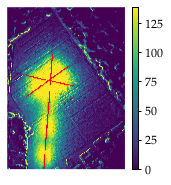

In [ ]:
show_hit_point_count(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=0, round_num=0, lines_only=False, dummy=False,
                     use_pgf=True, file_name="discussion_map_hit_count_round.pgf")
show_hit_point_count(FLIGHT_DAY_SEPTEMBER, RES_MEDIUM, flight_num=0, round_num=0, lines_only=True, dummy=False,
                     use_pgf=True, file_name="discussion_map_hit_count_lines.pgf")

# Appendix: Motor Correlation

In [ ]:
def show_motor_speed(spike_rate_resolution, flight_day, use_pgf = False, file_name = None):
    rows = 1 if flight_day == FLIGHT_DAY_AUGUST else 2
    bottom_space = 0.51 if flight_day == FLIGHT_DAY_AUGUST else 0.25
    label_spike_rate_top = 0.72 if flight_day == FLIGHT_DAY_AUGUST else 0.5
    
    fig = plt.figure(figsize=(PAGE_WIDTH, rows * 4.25))
    
    ax = None
    
    for flight_day in [flight_day]:
        flight_count = 2 if flight_day == FLIGHT_DAY_AUGUST else 4
        
        for flight_num in range(flight_count):
            spike_rate = get_spike_rate(flight_day, spike_rate_resolution, flight_num)
            speeds = motor_speeds[flight_day][spike_rate_resolution][flight_num]
            
            ax_num = flight_num + 1
            ax = fig.add_subplot(rows, 2, ax_num, xlim = (4000, 5200))
            
            for round_num in range(len(start_rounds[flight_day][flight_num])):
                start = get_start_round(spike_rate_resolution, flight_day, flight_num, round_num)
                end = get_end_round(spike_rate_resolution, flight_day, flight_num, round_num)
                spike_rate_round = spike_rate[start : end]
                
                mean_motor_speed = []
                for motor_num in range(4):
                    mean_motor_speed.append(speeds[motor_num][start : end])
                    
                mean_motor_speed = np.mean(np.array(mean_motor_speed), axis = 0)
                
                motor = []
                spike = []
                
                for window in range(0, len(mean_motor_speed), 20):
                    motor.append(np.mean(mean_motor_speed[window : window + 20]))
                    spike.append(np.mean(spike_rate_round[window : window + 20]))
                
                df = pd.DataFrame({'motor speed [RPM]': motor,
                                    'spike rate [Hz]': spike})

                r = Correlation._pearson(motor, spike)
                label = "Round {}, r = {:2.2f}".format(round_num + 1, r)
                sns.regplot(ax=ax, x="motor speed [RPM]", y="spike rate [Hz]", data = df, ci = None,
                            label=label, line_kws={'linewidth' : 1.0}, scatter_kws={'s':5.0})      
                
                # remove identical labels for all subplots
                ax.set_ylabel('')
                ax.set_xlabel('')
                
                ax.legend(loc = "upper center", bbox_to_anchor=(0, -0.5, 1, 0.3), fontsize = FONT_SIZE_LABEL,
                         handletextpad=0)
                
                ax.set_title("Flight {}".format(flight_num + 1), fontsize = FONT_SIZE_LABEL)
        
    fig.subplots_adjust(hspace = 1.2, wspace = 0.4, bottom = bottom_space, top = 0.95)
    
    fig.text(0.5, 0.02, 'motor speed [RPM]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.02, 0.5, 'spike rate [spikes/0.1s]', ha='center', va='center', rotation='vertical',
             fontsize = FONT_SIZE_LABEL)

    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show()

In [ ]:
show_motor_speed(RES_MEDIUM, FLIGHT_DAY_AUGUST, use_pgf=False, file_name='motor_speed_august.png')
show_motor_speed(RES_MEDIUM, FLIGHT_DAY_AUGUST, use_pgf=True, file_name='motor_speed_august.pgf')

show_motor_speed(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, use_pgf=False, file_name='motor_speed_september.png')
show_motor_speed(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, use_pgf=True, file_name='motor_speed_september.pgf')

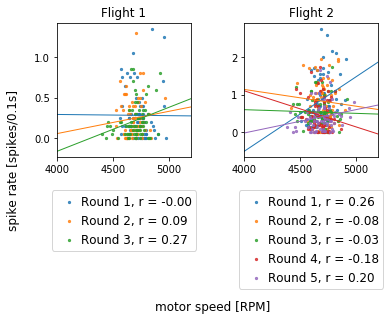

In [ ]:
show_motor_speed(RES_MEDIUM, FLIGHT_DAY_AUGUST)

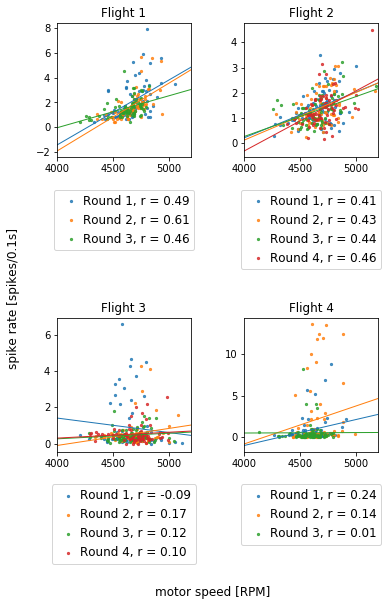

In [ ]:
show_motor_speed(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER)

In [ ]:
def show_motor_accel(spike_rate_resolution, flight_day, use_pgf = False, file_name = None):
    rows = 1 if flight_day == FLIGHT_DAY_AUGUST else 2
    bottom_space = 0.51 if flight_day == FLIGHT_DAY_AUGUST else 0.25
    label_spike_rate_top = 0.72 if flight_day == FLIGHT_DAY_AUGUST else 0.5
    
    fig = plt.figure(figsize=(PAGE_WIDTH, rows * 4.25))
    
    ax = None
    
    for flight_day in [flight_day]:
        flight_count = 2 if flight_day == FLIGHT_DAY_AUGUST else 4
        
        for flight_num in range(flight_count):
            spike_rate = get_spike_rate(flight_day, spike_rate_resolution, flight_num)
            accel = accelerations[flight_day][spike_rate_resolution][flight_num]
            
            ax_num = flight_num + 1
            ax = fig.add_subplot(rows, 2, ax_num)
            
            for round_num in range(len(start_rounds[flight_day][flight_num])):
                start = get_start_round(spike_rate_resolution, flight_day, flight_num, round_num)
                end = get_end_round(spike_rate_resolution, flight_day, flight_num, round_num)
                spike_rate_round = spike_rate[start : end]
                
                mean_motor_accel = []
                for axis_num in range(3):
                    mean_motor_accel.append(accel[axis_num][start : end])
                    
                mean_motor_accel = np.mean(np.array(mean_motor_accel), axis = 0)
                
                motor = []
                spike = []
                
                for window in range(0, len(mean_motor_accel), 20):
                    motor.append(np.mean(mean_motor_accel[window : window + 20]))
                    spike.append(np.mean(spike_rate_round[window : window + 20]))
                
                df = pd.DataFrame({'acceleration [Meters/second]': motor,
                                    'spike rate [Hz]': spike})

                r = Correlation._pearson(motor, spike)
                label = "Round {}, r = {:2.2f}".format(round_num + 1, r)
                sns.regplot(ax=ax, x="acceleration [Meters/second]", y="spike rate [Hz]", data = df, ci = None,
                            label=label, line_kws={'linewidth' : 1.0}, scatter_kws={'s':5.0})      
                
                # remove identical labels for all subplots
                ax.set_ylabel('')
                ax.set_xlabel('')
                
                ax.legend(loc = "upper center", bbox_to_anchor=(0, -0.5, 1, 0.3), fontsize = FONT_SIZE_LABEL,
                         handletextpad=0)
                
                ax.set_title("Flight {}".format(flight_num + 1), fontsize = FONT_SIZE_LABEL)
        
    fig.subplots_adjust(hspace = 1.2, wspace = 0.4, bottom = bottom_space, top = 0.95)
    
    fig.text(0.5, 0.02, 'acceleration [m/s]', ha='center', va='center', fontsize = FONT_SIZE_LABEL)
    fig.text(0.02, label_spike_rate_top, 'spike rate [spikes/0.1s]', ha='center', va='center', rotation='vertical',
             fontsize = FONT_SIZE_LABEL)

    if use_pgf:
        backend_pgf(fig, file_name)
    else:
        backend_inline(fig, file_name)
        plt.show()

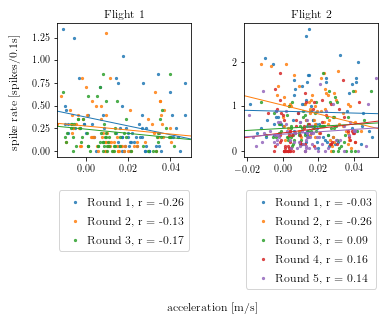

In [ ]:
show_motor_accel(RES_MEDIUM, FLIGHT_DAY_AUGUST, use_pgf=False, file_name='motor_accel_august.png')
show_motor_accel(RES_MEDIUM, FLIGHT_DAY_AUGUST, use_pgf=True, file_name='motor_accel_august.pgf')

show_motor_accel(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, use_pgf=False, file_name='motor_accel_september.png')
show_motor_accel(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER, use_pgf=True, file_name='motor_accel_september.pgf')

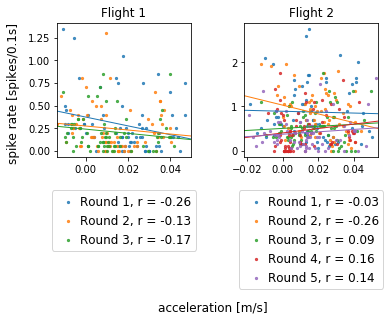

In [ ]:
show_motor_accel(RES_MEDIUM, FLIGHT_DAY_AUGUST)

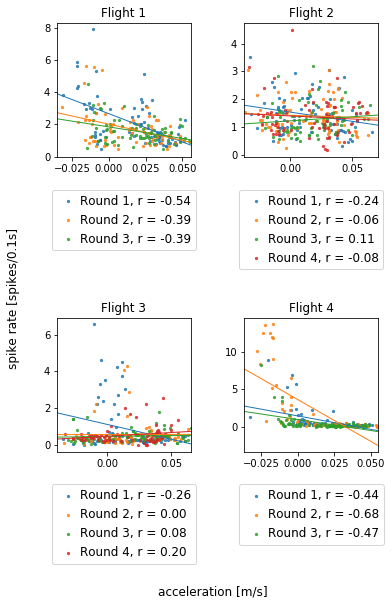

In [ ]:
show_motor_accel(RES_MEDIUM, FLIGHT_DAY_SEPTEMBER)